In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [2]:
votes_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_user.parquet")
school_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_group.parquet")

In [3]:
# 날짜 정제
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.date

# 해당 기간(4/28 ~ 5/25)에 투표한 유저 ID
target_user_ids = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] < pd.to_datetime("2023-08-01").date())
]["user_id"].unique()

# school_id가 존재하는 group만 추출
school_df_valid = school_df[school_df["school_id"].notnull()].copy()

# school_id를 유저에게 붙이기 (users → school_df)
users_with_school = users_df.merge(
    school_df_valid[["id", "school_id"]],
    left_on="group_id", right_on="id", how="left"
).drop(columns="id_y").rename(columns={"id_x": "user_id"})

# 해당 유저 중에서 위 기간에 투표한 유저만 필터링
target_users = users_with_school[users_with_school["user_id"].isin(target_user_ids)]

# 투표한 유저가 소속된 학교 ID들 (유니크)
active_school_ids = target_users["school_id"].dropna().unique()
print(" 해당 기간에 투표 발생한 학교 수:", len(active_school_ids))

# 이 학교 ID에 속한 전체 유저 수
final_user_count = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].nunique()

print(" 해당 학교에 소속된 유저 수:", final_user_count)

 해당 기간에 투표 발생한 학교 수: 10
 해당 학교에 소속된 유저 수: 5090


In [4]:
active_school_ids

array([ 271.,  369., 5491.,  352., 4516., 4426., 1478., 5520., 5372.,
       1719.])

In [5]:
# 해당 학교에 속한 유저 ID 목록
target_school_user_ids = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].unique()

# 해당 유저 중에서 4/28 ~ 5/25 기간에 투표한 유저 수
voted_users_in_target_schools = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] < pd.to_datetime("2023-08-01").date()) &
    (votes_df["user_id"].isin(target_school_user_ids))
]["user_id"].nunique()

print(" 해당 10개 학교 유저 중 실제 투표한 유저 수:", voted_users_in_target_schools)

 해당 10개 학교 유저 중 실제 투표한 유저 수: 4845


## 리텐션율

In [6]:
# vote_date 파싱
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.normalize()

# cohort_day (첫 투표일) 생성
cohort_df = votes_df.groupby("user_id")["vote_date"].min().reset_index(name="cohort_day")

# 대상 유저만 필터링 (4703명)
votes_filtered_df = votes_df[votes_df["user_id"].isin(target_user_ids)].copy()
votes_filtered_df = votes_filtered_df.merge(cohort_df, on="user_id", how="left")

# active_day 계산
votes_filtered_df["active_day"] = (votes_filtered_df["vote_date"] - votes_filtered_df["cohort_day"]).dt.days

# 기간 필터 (cohort_day 기준 4/29~5/25 사이)
votes_filtered_df = votes_filtered_df[
    (votes_filtered_df["cohort_day"] >= "2023-04-28") &
    (votes_filtered_df["cohort_day"] < "2023-08-01") &
    (votes_filtered_df["active_day"] >= 0)
]

# cohort 크기 계산
cohort_size_df = votes_filtered_df.groupby("cohort_day")["user_id"].nunique().reset_index(name="cohort_size")

# active_day별 유지 유저 수
retained_df = votes_filtered_df.groupby(["cohort_day", "active_day"])["user_id"] \
    .nunique().reset_index(name="retained")

# 리텐션율 계산
ret_df = retained_df.merge(cohort_size_df, on="cohort_day")
ret_df["rate"] = ret_df["retained"] / ret_df["cohort_size"]

In [7]:
# ---------- 피벗: Day 0~28 ----------
heat_df  = ret_df.pivot(index="cohort_day",
                        columns="active_day",
                        values="rate").fillna(0)
heat_28  = heat_df.loc[:, :28]

# ---------- 컬러맵 ----------
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "team_palette", ["#ffc107", "#009688"], N=256
)

# ---------- 히트맵 ----------
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    heat_28,
    cmap=custom_cmap,
    annot=heat_28.applymap(lambda x: f"{x:.1%}"),
    fmt="",
    annot_kws={"size": 7, "color": "black"},
    linewidths=0.5,
    linecolor="white",
    vmin=0, vmax=1,
    cbar_kws={
        "label": "Retention Rate",
        "format": ticker.PercentFormatter(xmax=1, decimals=0),
        "ticks": [0, 0.25, 0.5, 0.75, 1.0]
    }
)

# ---------- 축 레이블 설정 ----------
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel("Days Since First Vote", fontsize=14)
ax.set_ylabel("Cohort First Vote Date", fontsize=14)

# Y축(코호트 날짜) 한 번만 지정
ax.set_yticks(np.arange(len(heat_28.index)) + 0.5)  # 셀 중앙 정렬
ax.set_yticklabels(
    heat_28.index.strftime('%Y-%m-%d'),
    rotation=0,
    fontsize=10
)

plt.title("4/28–5/25 코호트별 Day 0–28 리텐션", fontsize=18, pad=20)
plt.tight_layout()
plt.show()

NameError: name 'mcolors' is not defined

In [10]:
#  피벗 테이블 (Day 0~28)
heat_df = ret_df.pivot(index="cohort_day", columns="active_day", values="rate").fillna(0)
heat_28 = heat_df.loc[:, :28].copy()  # Day 0~28만 선택

# cohort_size_df를 인덱스를 기준으로 merge
# cohort_size_df의 'cohort_day'를 인덱스로 설정
cohort_size_df_indexed = cohort_size_df.set_index("cohort_day")

#  병합
heat_with_size = cohort_size_df_indexed.join(heat_28)

heat_with_size.head()

,cohort_size,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,24,25,26,27,28
cohort_day,,,,,,,,,,,,,,,,,,,,,
2023-04-28,125,1.0,0.976000,0.904000,0.808000,0.904000,0.720000,0.616000,0.600000,0.560000,...,0.152000,0.104000,0.112000,0.096000,0.120000,0.064000,0.056000,0.080000,0.088000,0.072000
2023-04-29,99,1.0,0.989899,0.858586,0.898990,0.838384,0.676768,0.636364,0.646465,0.515152,...,0.101010,0.111111,0.080808,0.070707,0.050505,0.020202,0.060606,0.020202,0.070707,0.151515
2023-04-30,114,1.0,0.903509,0.947368,0.894737,0.692982,0.701754,0.719298,0.570175,0.526316,...,0.184211,0.184211,0.175439,0.131579,0.140351,0.149123,0.140351,0.157895,0.131579,0.228070
2023-05-01,36,1.0,0.861111,0.833333,0.638889,0.722222,0.555556,0.638889,0.583333,0.444444,...,0.166667,0.166667,0.166667,0.055556,0.166667,0.138889,0.250000,0.222222,0.166667,0.222222
2023-05-02,72,1.0,0.944444,0.833333,0.833333,0.833333,0.819444,0.625000,0.569444,0.569444,...,0.166667,0.152778,0.208333,0.125000,0.125000,0.125000,0.236111,0.208333,0.250000,0.166667


In [11]:
heat_with_size

,cohort_size,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,24,25,26,27,28
cohort_day,,,,,,,,,,,,,,,,,,,,,
2023-04-28,125,1.0,0.976000,0.904000,0.808000,0.904000,0.720000,0.616000,0.600000,0.560000,...,0.152000,0.104000,0.112000,0.096000,0.120000,0.064000,0.056000,0.080000,0.088000,0.072000
2023-04-29,99,1.0,0.989899,0.858586,0.898990,0.838384,0.676768,0.636364,0.646465,0.515152,...,0.101010,0.111111,0.080808,0.070707,0.050505,0.020202,0.060606,0.020202,0.070707,0.151515
2023-04-30,114,1.0,0.903509,0.947368,0.894737,0.692982,0.701754,0.719298,0.570175,0.526316,...,0.184211,0.184211,0.175439,0.131579,0.140351,0.149123,0.140351,0.157895,0.131579,0.228070
2023-05-01,36,1.0,0.861111,0.833333,0.638889,0.722222,0.555556,0.638889,0.583333,0.444444,...,0.166667,0.166667,0.166667,0.055556,0.166667,0.138889,0.250000,0.222222,0.166667,0.222222
2023-05-02,72,1.0,0.944444,0.833333,0.833333,0.833333,0.819444,0.625000,0.569444,0.569444,...,0.166667,0.152778,0.208333,0.125000,0.125000,0.125000,0.236111,0.208333,0.250000,0.166667
2023-05-03,383,1.0,0.906005,0.921671,0.877285,0.822454,0.684073,0.608355,0.501305,0.422977,...,0.078329,0.075718,0.078329,0.060052,0.080940,0.125326,0.138381,0.143603,0.096606,0.080940
2023-05-04,167,1.0,0.928144,0.904192,0.838323,0.634731,0.556886,0.497006,0.419162,0.335329,...,0.071856,0.065868,0.053892,0.065868,0.101796,0.065868,0.077844,0.041916,0.035928,0.035928
2023-05-05,436,1.0,0.938073,0.857798,0.759174,0.594037,0.568807,0.438073,0.376147,0.316514,...,0.082569,0.071101,0.080275,0.137615,0.130734,0.130734,0.068807,0.064220,0.055046,0.084862
2023-05-06,183,1.0,0.885246,0.814208,0.710383,0.573770,0.540984,0.382514,0.355191,0.327869,...,0.038251,0.054645,0.136612,0.065574,0.087432,0.060109,0.081967,0.021858,0.060109,0.043716


In [12]:
# 색상 컬러맵 (노랑 → 청록)
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "team_palette", ["#ffc107", "#009688"], N=256
)

# 1. 리텐션 값만 슬라이싱 (Day 0~28)
retention_values = heat_with_size.iloc[:, 1:]  # cohort_size 제외

# 2. 주석용 데이터프레임: 퍼센트로 포맷팅
annot_df = retention_values.applymap(lambda x: f"{x:.1%}")

# 3. y축 라벨에 cohort_size 포함
yticklabels = [
    f"{idx.strftime('%Y-%m-%d')} ({int(row['cohort_size'])})"
    for idx, row in heat_with_size.iterrows()
]

# 4. 히트맵 시각화
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    retention_values,
    cmap=custom_cmap,
    annot=annot_df,
    fmt="",
    annot_kws={"size": 7, "color": "black"},
    linewidths=0.5,
    linecolor="white",
    vmin=0, vmax=1,
    cbar_kws={
        "label": "Retention Rate",
        "format": ticker.PercentFormatter(xmax=1, decimals=0),
        "ticks": [0, 0.25, 0.5, 0.75, 1.0]
    }
)

# 축 설정
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(rotation=0, fontsize=12)
ax.set_yticklabels(yticklabels, rotation=0, fontsize=10)

# 제목/레이블
plt.title("4/29~5/25 코호트별 리텐션 ", fontsize=18, pad=20, loc='center')
plt.xlabel("Days Since First Vote", fontsize=14)
plt.ylabel("Cohort First Vote Date", fontsize=14)

plt.tight_layout()
plt.show()

NameError: name 'mcolors' is not defined

In [13]:
heat_28 = (heat_28 * 100).round(1)
display(heat_28)

active_day,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
cohort_day,,,,,,,,,,,,,,,,,,,,,
2023-04-28,100.0,97.6,90.4,80.8,90.4,72.0,61.6,60.0,56.0,48.8,...,15.2,10.4,11.2,9.6,12.0,6.4,5.6,8.0,8.8,7.2
2023-04-29,100.0,99.0,85.9,89.9,83.8,67.7,63.6,64.6,51.5,45.5,...,10.1,11.1,8.1,7.1,5.1,2.0,6.1,2.0,7.1,15.2
2023-04-30,100.0,90.4,94.7,89.5,69.3,70.2,71.9,57.0,52.6,54.4,...,18.4,18.4,17.5,13.2,14.0,14.9,14.0,15.8,13.2,22.8
2023-05-01,100.0,86.1,83.3,63.9,72.2,55.6,63.9,58.3,44.4,30.6,...,16.7,16.7,16.7,5.6,16.7,13.9,25.0,22.2,16.7,22.2
2023-05-02,100.0,94.4,83.3,83.3,83.3,81.9,62.5,56.9,56.9,43.1,...,16.7,15.3,20.8,12.5,12.5,12.5,23.6,20.8,25.0,16.7
2023-05-03,100.0,90.6,92.2,87.7,82.2,68.4,60.8,50.1,42.3,33.2,...,7.8,7.6,7.8,6.0,8.1,12.5,13.8,14.4,9.7,8.1
2023-05-04,100.0,92.8,90.4,83.8,63.5,55.7,49.7,41.9,33.5,24.0,...,7.2,6.6,5.4,6.6,10.2,6.6,7.8,4.2,3.6,3.6
2023-05-05,100.0,93.8,85.8,75.9,59.4,56.9,43.8,37.6,31.7,33.5,...,8.3,7.1,8.0,13.8,13.1,13.1,6.9,6.4,5.5,8.5
2023-05-06,100.0,88.5,81.4,71.0,57.4,54.1,38.3,35.5,32.8,24.6,...,3.8,5.5,13.7,6.6,8.7,6.0,8.2,2.2,6.0,4.4


In [14]:
cohort_size_df

,cohort_day,cohort_size
0,2023-04-28,125
1,2023-04-29,99
2,2023-04-30,114
3,2023-05-01,36
4,2023-05-02,72
5,2023-05-03,383
6,2023-05-04,167
7,2023-05-05,436
8,2023-05-06,183
9,2023-05-07,105


In [15]:
cohort_size_df["cohort_size"].sum()

4845

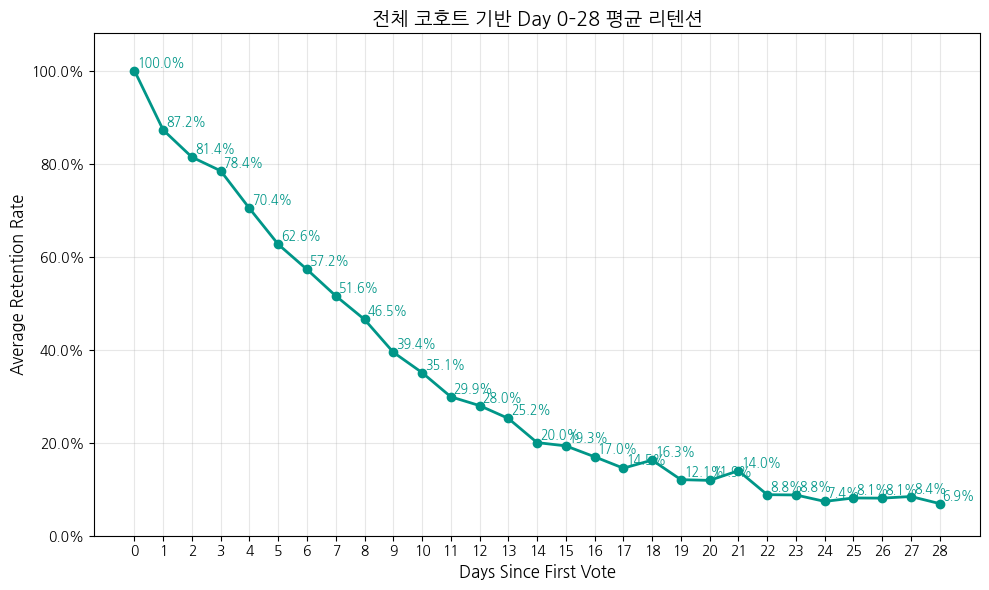

In [16]:
# 수치 추가 후 조절

from matplotlib import ticker

# 평균 리텐션 계산 (Day 0~28)
avg_retention = (
    ret_df[ret_df["active_day"] <= 28]
    .groupby("active_day")["rate"]
    .mean()
    .reset_index()
)

# 라인 그래프 
plt.figure(figsize=(10, 6))
plt.plot(
    avg_retention["active_day"],
    avg_retention["rate"],
    marker="o",
    color="#009688",  #
    linewidth=2,
    label="평균 리텐션율"
)

# 각 점 위에 수치 표시
# 수치 표시를 좀 더 보기 좋게 띄워서 추가
for x, y in zip(avg_retention["active_day"], avg_retention["rate"]):
    plt.text(x + 0.1, y + 0.03, f"{y:.1%}", ha="left", va="top", fontsize=9, color="#009688")



# 레이블/그리드/포맷 설정
plt.xticks(range(0, 29))
plt.xlabel("Days Since First Vote", fontsize=12)
plt.ylabel("Average Retention Rate", fontsize=12)
plt.title("전체 코호트 기반 Day 0–28 평균 리텐션", fontsize=14)
plt.grid(alpha=0.3)
plt.ylim(0, 1.08)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.tight_layout()
plt.show()

In [17]:
avg_retention

,active_day,rate
0,0,1.000000
1,1,0.872236
2,2,0.813793
3,3,0.784372
4,4,0.703644
5,5,0.626400
6,6,0.572427
7,7,0.515598
8,8,0.464947
9,9,0.394410


## 마스터 테이블

In [19]:
# 날짜 파싱
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.date

# 기간 필터링: 4월 29일 ~ 5월 25일
votes_filtered_df = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] < pd.to_datetime("2023-08-01").date())
].copy()

In [20]:
# school_id가 존재하는 group만 필터링
school_df_valid = school_df[school_df["school_id"].notnull()].copy()

# 유저와 school 정보 연결
users_with_school = users_df.merge(
    school_df_valid[["id", "school_id"]],
    left_on="group_id", right_on="id", how="left"
).drop(columns="id_y").rename(columns={"id_x": "user_id"})

# 해당 기간에 투표한 유저 ID
target_user_ids = votes_filtered_df["user_id"].unique()

# 이 유저들 중 소속 학교 ID들 추출
target_users = users_with_school[users_with_school["user_id"].isin(target_user_ids)]
active_school_ids = target_users["school_id"].dropna().unique()

In [21]:
# 해당 10개 학교에 속한 유저만 추출
target_school_user_ids = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].unique()

# 최종 유저로 vote 데이터 다시 필터링
votes_filtered_df = votes_filtered_df[
    votes_filtered_df["user_id"].isin(target_school_user_ids)
].copy()

In [22]:
# 유저별 행동 요약 집계
master_df = votes_filtered_df.groupby("user_id").agg(
    total_votes=("question_piece_id", "count"),
    unique_days=("vote_date", "nunique"),
    first_vote=("vote_date", "min"),
    last_vote=("vote_date", "max")
).reset_index()

# 활동 기간 추가 (일 단위)
master_df["active_days"] = (pd.to_datetime(master_df["last_vote"]) - pd.to_datetime(master_df["first_vote"])).dt.days

In [23]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days
0,838023,22,5,2023-04-29,2023-05-04,5
1,838466,129,7,2023-05-02,2023-06-02,31
2,838642,10,2,2023-04-28,2023-04-29,1
3,839357,212,9,2023-04-29,2023-05-26,27
4,840293,170,7,2023-05-03,2023-05-15,12
...,...,...,...,...,...,...
4840,1577436,6,2,2023-07-05,2023-07-13,8
4841,1577437,47,3,2023-06-29,2023-07-11,12
4842,1577440,12,2,2023-06-29,2023-06-30,1
4843,1578095,10,1,2023-07-11,2023-07-11,0


In [24]:
# cohort_day 컬럼 생성
master_df["cohort_day"] = pd.to_datetime(master_df["first_vote"])

In [25]:
master_df["cohort_day"]

0      2023-04-29
1      2023-05-02
2      2023-04-28
3      2023-04-29
4      2023-05-03
          ...    
4840   2023-07-05
4841   2023-06-29
4842   2023-06-29
4843   2023-07-11
4844   2023-07-25
Name: cohort_day, Length: 4845, dtype: datetime64[ns]

In [26]:
#  Day 8 리텐션 정보만 추출
day8_ret_df = ret_df[ret_df["active_day"] == 8][["cohort_day", "rate"]].copy()
day8_ret_df.rename(columns={"rate": "retention_day8"}, inplace=True)

In [27]:
#  cohort_day 기준으로 리텐션 정보 병합
master_df = master_df.merge(day8_ret_df, on="cohort_day", how="left")

In [28]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977
...,...,...,...,...,...,...,...,...
4840,1577436,6,2,2023-07-05,2023-07-13,8,2023-07-05,1.000000
4841,1577437,47,3,2023-06-29,2023-07-11,12,2023-06-29,NaN
4842,1577440,12,2,2023-06-29,2023-06-30,1,2023-06-29,NaN
4843,1578095,10,1,2023-07-11,2023-07-11,0,2023-07-11,NaN


In [29]:
# 리텐션 그룹 컬럼 생성
master_df["ret_group"] = master_df["retention_day8"].apply(
    lambda x: "50 이상" if x >= 0.5 else "50 미만"
)

In [30]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,50 이상
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,50 이상
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,50 이상
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만
...,...,...,...,...,...,...,...,...,...
4840,1577436,6,2,2023-07-05,2023-07-13,8,2023-07-05,1.000000,50 이상
4841,1577437,47,3,2023-06-29,2023-07-11,12,2023-06-29,NaN,50 미만
4842,1577440,12,2,2023-06-29,2023-06-30,1,2023-06-29,NaN,50 미만
4843,1578095,10,1,2023-07-11,2023-07-11,0,2023-07-11,NaN,50 미만


In [31]:
# 리텐션 그룹 별로 분리된 컬럼 생성
master_df["ret_group_over"] = master_df["ret_group"].apply(
    lambda x: "50 이상" if x == "50 이상" else None
)

master_df["ret_group_under"] = master_df["ret_group"].apply(
    lambda x: "50 미만" if x == "50 미만" else None
)

In [32]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,ret_group_under
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상,50 이상,None
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,50 이상,50 이상,None
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,50 이상,50 이상,None
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,50 이상,50 이상,None
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만,None,50 미만
...,...,...,...,...,...,...,...,...,...,...,...
4840,1577436,6,2,2023-07-05,2023-07-13,8,2023-07-05,1.000000,50 이상,50 이상,None
4841,1577437,47,3,2023-06-29,2023-07-11,12,2023-06-29,NaN,50 미만,None,50 미만
4842,1577440,12,2,2023-06-29,2023-06-30,1,2023-06-29,NaN,50 미만,None,50 미만
4843,1578095,10,1,2023-07-11,2023-07-11,0,2023-07-11,NaN,50 미만,None,50 미만


In [33]:
master_df["ret_group_over"].count()

1877

In [34]:
master_df["ret_group_under"].count()

2968

In [35]:
# 이미 확보된 기준 유저 목록: target_user_ids (4703명)
# user_meta_df 생성 (기존 방식)
user_meta_df = users_df[["id", "gender", "group_id"]].rename(columns={"id": "user_id"})
school_info_df = school_df.rename(columns={"id": "group_id"})[["group_id", "school_id", "grade"]]
user_meta_df = user_meta_df.merge(school_info_df, on="group_id", how="left")

# 필터링: 리텐션 대상 유저만 남기기
user_meta_df = user_meta_df[user_meta_df["user_id"].isin(target_user_ids)].copy()

In [36]:
user_meta_df

,user_id,gender,group_id,school_id,grade
396,838023,F,233.0,271.0,1.0
633,838466,F,321.0,369.0,2.0
756,838642,F,356.0,271.0,2.0
1252,839357,M,519.0,271.0,1.0
1889,840293,F,838.0,369.0,1.0
...,...,...,...,...,...
671241,1577436,F,34351.0,5520.0,3.0
671242,1577437,F,9568.0,4516.0,1.0
671244,1577440,M,8323.0,4516.0,1.0
671809,1578095,F,1058.0,369.0,2.0


In [37]:
master_df = master_df.merge(user_meta_df, on="user_id", how="left")

In [38]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,ret_group_under,gender,group_id,school_id,grade
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상,50 이상,None,F,233.0,271.0,1.0
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,50 이상,50 이상,None,F,321.0,369.0,2.0
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,50 이상,50 이상,None,F,356.0,271.0,2.0
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,50 이상,50 이상,None,M,519.0,271.0,1.0
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만,None,50 미만,F,838.0,369.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840,1577436,6,2,2023-07-05,2023-07-13,8,2023-07-05,1.000000,50 이상,50 이상,None,F,34351.0,5520.0,3.0
4841,1577437,47,3,2023-06-29,2023-07-11,12,2023-06-29,NaN,50 미만,None,50 미만,F,9568.0,4516.0,1.0
4842,1577440,12,2,2023-06-29,2023-06-30,1,2023-06-29,NaN,50 미만,None,50 미만,M,8323.0,4516.0,1.0
4843,1578095,10,1,2023-07-11,2023-07-11,0,2023-07-11,NaN,50 미만,None,50 미만,F,1058.0,369.0,2.0


In [39]:
master_df["ret_group_over"].count()

1877

In [40]:
master_df["ret_group_under"].count()

2968

### 리텐션 그룹별 유저 필터링

In [55]:
# 1. 그룹별 유저 필터링
over_df = master_df[master_df["ret_group_over"] == "50 이상"]
under_df = master_df[master_df["ret_group_under"] == "50 미만"]

In [56]:
over_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,ret_group_under,gender,group_id,school_id,grade
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상,50 이상,None,F,233.0,271.0,1.0
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,50 이상,None,F,321.0,369.0,2.0
2,838642,1,1,2023-04-29,2023-04-29,0,2023-04-29,0.515152,50 이상,50 이상,None,F,356.0,271.0,2.0
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.515152,50 이상,50 이상,None,M,519.0,271.0,1.0
7,840512,131,7,2023-05-02,2023-05-16,14,2023-05-02,0.569444,50 이상,50 이상,None,M,930.0,369.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404,1437690,373,5,2023-05-21,2023-05-25,4,2023-05-21,0.544974,50 이상,50 이상,None,M,70578.0,4426.0,3.0
4407,1437718,131,5,2023-05-21,2023-05-25,4,2023-05-21,0.544974,50 이상,50 이상,None,F,70737.0,4426.0,3.0
4408,1437799,44,5,2023-05-21,2023-05-25,4,2023-05-21,0.544974,50 이상,50 이상,None,M,64837.0,4426.0,2.0
4409,1437813,102,5,2023-05-21,2023-05-25,4,2023-05-21,0.544974,50 이상,50 이상,None,M,73850.0,4426.0,2.0


In [57]:
under_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,ret_group_under,gender,group_id,school_id,grade
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만,None,50 미만,F,838.0,369.0,1.0
5,840473,165,12,2023-05-03,2023-05-21,18,2023-05-03,0.422977,50 미만,None,50 미만,M,915.0,369.0,1.0
6,840474,41,5,2023-05-03,2023-05-08,5,2023-05-03,0.422977,50 미만,None,50 미만,F,916.0,369.0,1.0
10,841333,338,11,2023-05-03,2023-05-16,13,2023-05-03,0.422977,50 미만,None,50 미만,M,1212.0,369.0,3.0
12,841809,543,16,2023-05-03,2023-05-20,17,2023-05-03,0.422977,50 미만,None,50 미만,F,1379.0,369.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,M,73885.0,4426.0,2.0
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,F,29558.0,5520.0,2.0
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,F,72313.0,4426.0,2.0
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,F,72313.0,4426.0,2.0


## 하위지표

### 1. 첫날 투표 건 수

In [58]:
# first_vote 컬럼에서 가장 이른 날짜
first_day = pd.to_datetime(master_df['first_vote']).min()

# 가장 이른 날짜에 first_vote를 한 유저 수 = 첫 투표일에 투표한 유저 수
first_day_user_count = (pd.to_datetime(master_df['first_vote']) == first_day).sum()

first_day, first_day_user_count

(Timestamp('2023-04-29 00:00:00'), 221)

In [59]:
# 2023-04-29에 first_vote를 한 유저 수
count_april_29 = (pd.to_datetime(master_df['first_vote']) == pd.Timestamp("2023-04-29")).sum()
count_april_29


221

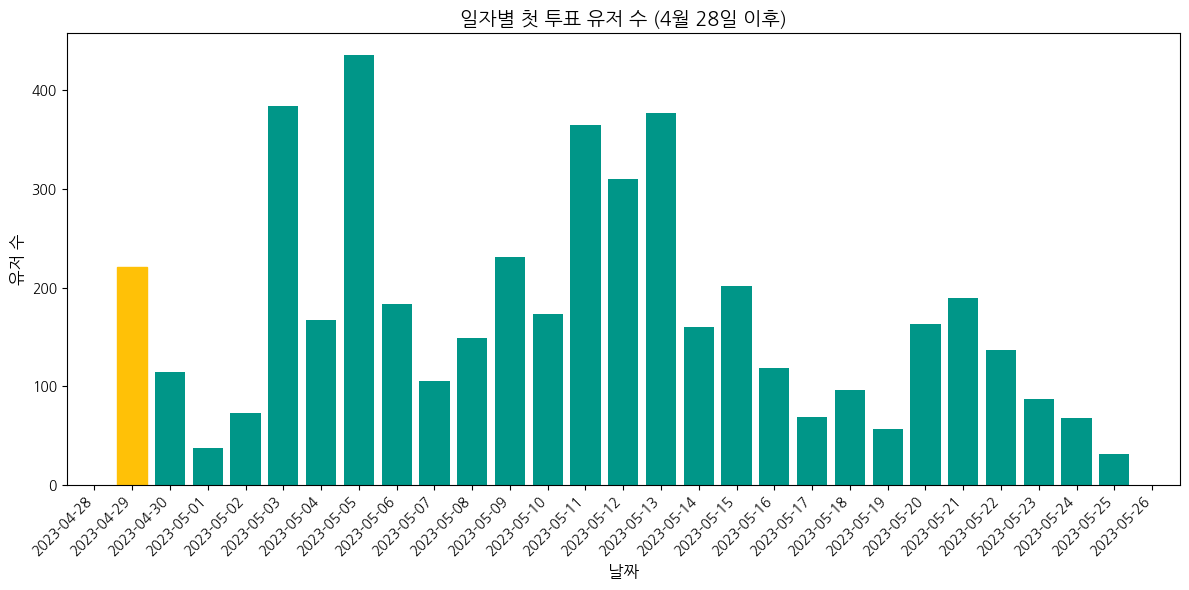

In [60]:
import matplotlib.dates as mdates 

master_df['first_vote'] = pd.to_datetime(master_df['first_vote'])

# 시각화에 사용할 데이터: 4월 28일 이후 first_vote 날짜별 유저 수
first_vote_counts = master_df['first_vote'].value_counts().sort_index()
filtered_counts = first_vote_counts[first_vote_counts.index >= pd.Timestamp("2023-04-28")]

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(filtered_counts.index, filtered_counts.values, color="#009688")

# 2023-04-29 강조
for i, bar in enumerate(bars):
    if filtered_counts.index[i] == pd.Timestamp("2023-04-29"):
        bar.set_color("#ffc107")

plt.title("일자별 첫 투표 유저 수 (4월 28일 이후)", fontsize=14)
plt.xlabel("날짜", fontsize=12)
plt.ylabel("유저 수", fontsize=12)

# x축 날짜 포맷
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [61]:

# created_at을 datetime으로
votes_df['created_at'] = pd.to_datetime(votes_df['created_at'])

# 1. 유저별 첫 투표일 계산
first_vote_df = votes_df.groupby('user_id')['created_at'].min().reset_index(name='first_vote')

# 2. votes_df에 병합하여 first_vote 정보 포함
votes_with_first = votes_df.merge(first_vote_df, on='user_id', how='left')

# 3. 날짜 단위로 변환
votes_with_first['created_date'] = votes_with_first['created_at'].dt.date
votes_with_first['first_vote_date'] = votes_with_first['first_vote'].dt.date

# 4. 날짜 기준 필터링 (2023-04-29)
final_filtered_votes = votes_with_first[
    (votes_with_first['first_vote_date'] == pd.to_datetime('2023-04-29').date()) &
    (votes_with_first['created_date'] == pd.to_datetime('2023-04-29').date())
]

# 5. 최종 투표 건수 출력
print("2023-04-29 처음 투표한 유저들이 남긴 실제 투표 건수:", len(final_filtered_votes))


2023-04-29 처음 투표한 유저들이 남긴 실제 투표 건수: 2797


In [62]:
final_filtered_votes

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,vote_date,first_vote,created_date,first_vote_date
3256,818217,C,2023-04-29 00:20:51,850215,249,849977,1038418,0,N,2023-04-29 00:20:51,0,0,2023-04-29,2023-04-29 00:20:51,2023-04-29,2023-04-29
3257,818235,C,2023-04-29 00:21:06,850811,113,849977,1038420,0,N,2023-04-29 00:21:06,0,0,2023-04-29,2023-04-29 00:20:51,2023-04-29,2023-04-29
3258,818241,C,2023-04-29 00:21:15,850811,144,849977,1038421,0,N,2023-04-29 00:21:15,0,0,2023-04-29,2023-04-29 00:20:51,2023-04-29,2023-04-29
3259,818247,C,2023-04-29 00:21:22,850215,268,849977,1038422,0,N,2023-04-29 00:21:22,0,0,2023-04-29,2023-04-29 00:20:51,2023-04-29,2023-04-29
3260,818257,C,2023-04-29 00:21:32,850334,281,849977,1038423,0,N,2023-04-29 00:21:32,0,0,2023-04-29,2023-04-29 00:20:51,2023-04-29,2023-04-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14560,1051414,C,2023-04-29 23:57:36,850986,125,851929,1299133,0,N,2023-04-29 23:57:36,0,0,2023-04-29,2023-04-29 09:14:05,2023-04-29,2023-04-29
14561,1051437,C,2023-04-29 23:57:43,849487,273,851929,1299134,0,N,2023-04-29 23:57:43,0,0,2023-04-29,2023-04-29 09:14:05,2023-04-29,2023-04-29
14562,1051451,C,2023-04-29 23:57:49,849487,283,851929,1299135,0,N,2023-04-29 23:57:49,0,0,2023-04-29,2023-04-29 09:14:05,2023-04-29,2023-04-29
14563,1051493,C,2023-04-29 23:58:06,850229,274,851929,1299136,0,N,2023-04-29 23:58:06,0,0,2023-04-29,2023-04-29 09:14:05,2023-04-29,2023-04-29


In [63]:
# CSV 저장

csv_path = "/home/eunyu/final_filtered_votes_20230429.csv"

final_filtered_votes.to_csv(csv_path, index=False)

In [64]:
# 먼저 retention_day8 기준으로 High / Low 코호트 구분
high_users = over_df[over_df['retention_day8'] >= 0.5]['user_id']
low_users = under_df[under_df['retention_day8'] < 0.5]['user_id']

# High 코호트 유저 중 4/29에 first_vote한 사람들
high_first_429 = votes_with_first[
    (votes_with_first['user_id'].isin(high_users)) &
    (votes_with_first['first_vote_date'] == pd.to_datetime('2023-04-29').date()) &
    (votes_with_first['created_date'] == pd.to_datetime('2023-04-29').date())
]

# Low 코호트 유저 중 4/29에 first_vote한 사람들
low_first_429 = votes_with_first[
    (votes_with_first['user_id'].isin(low_users)) &
    (votes_with_first['first_vote_date'] == pd.to_datetime('2023-04-29').date()) &
    (votes_with_first['created_date'] == pd.to_datetime('2023-04-29').date())
]

# 두 집단의 4/29 실제 투표 건수 비교
high_count = len(high_first_429)
low_count = len(low_first_429)

high_count, low_count


(2797, 0)

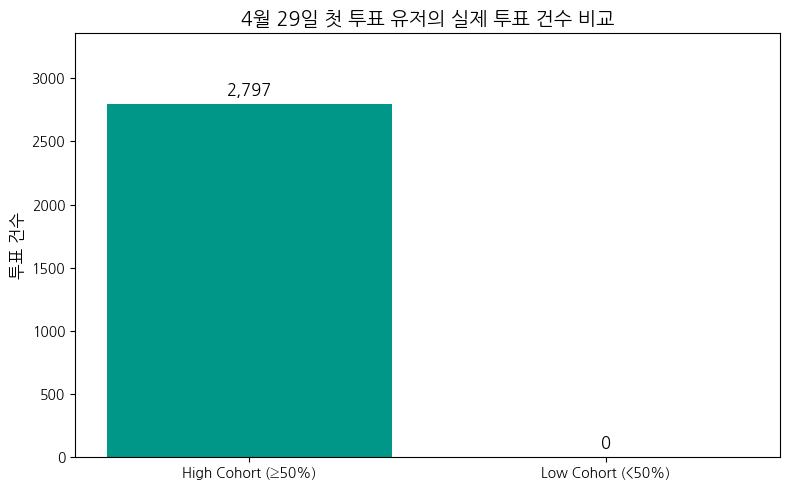

In [65]:

# 시각화용 데이터 준비
labels = ['High Cohort (≥50%)', 'Low Cohort (<50%)']
values = [high_count, low_count]
colors = ['#009688', '#ffc107']

# 막대그래프 그리기
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=colors)

# 값 라벨 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, f'{yval:,}', ha='center', va='bottom', fontsize=12)

plt.title('4월 29일 첫 투표 유저의 실제 투표 건수 비교', fontsize=14)
plt.ylabel('투표 건수', fontsize=12)
plt.ylim(0, max(values) * 1.2)
plt.tight_layout()
plt.show()

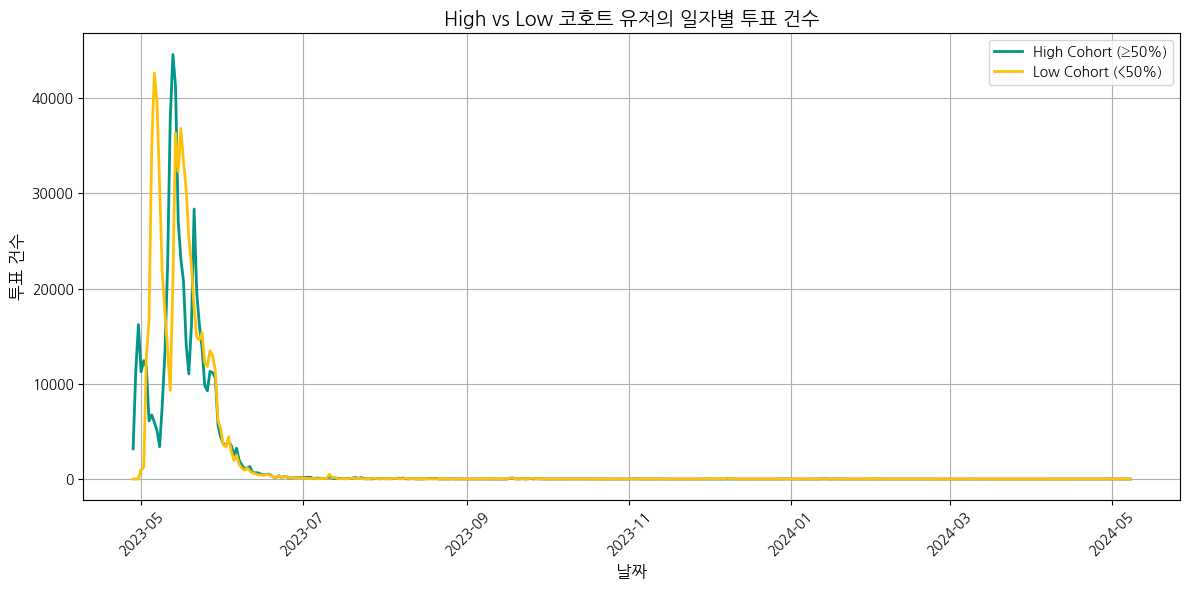

In [66]:
# 각 그룹별 투표 로그 추출
votes_high = votes_df[votes_df['user_id'].isin(high_users)]
votes_low = votes_df[votes_df['user_id'].isin(low_users)]

# 일자별 투표 건수 집계
high_daily = votes_high.groupby('vote_date')['user_id'].count().reset_index(name='high_votes')
low_daily = votes_low.groupby('vote_date')['user_id'].count().reset_index(name='low_votes')

# 병합 및 정렬
daily_comparison = pd.merge(high_daily, low_daily, on='vote_date', how='outer').fillna(0).sort_values('vote_date')

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(daily_comparison['vote_date'], daily_comparison['high_votes'], label='High Cohort (≥50%)', color='#009688', linewidth=2)
plt.plot(daily_comparison['vote_date'], daily_comparison['low_votes'], label='Low Cohort (<50%)', color='#ffc107', linewidth=2)

plt.title('High vs Low 코호트 유저의 일자별 투표 건수', fontsize=14)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('투표 건수', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

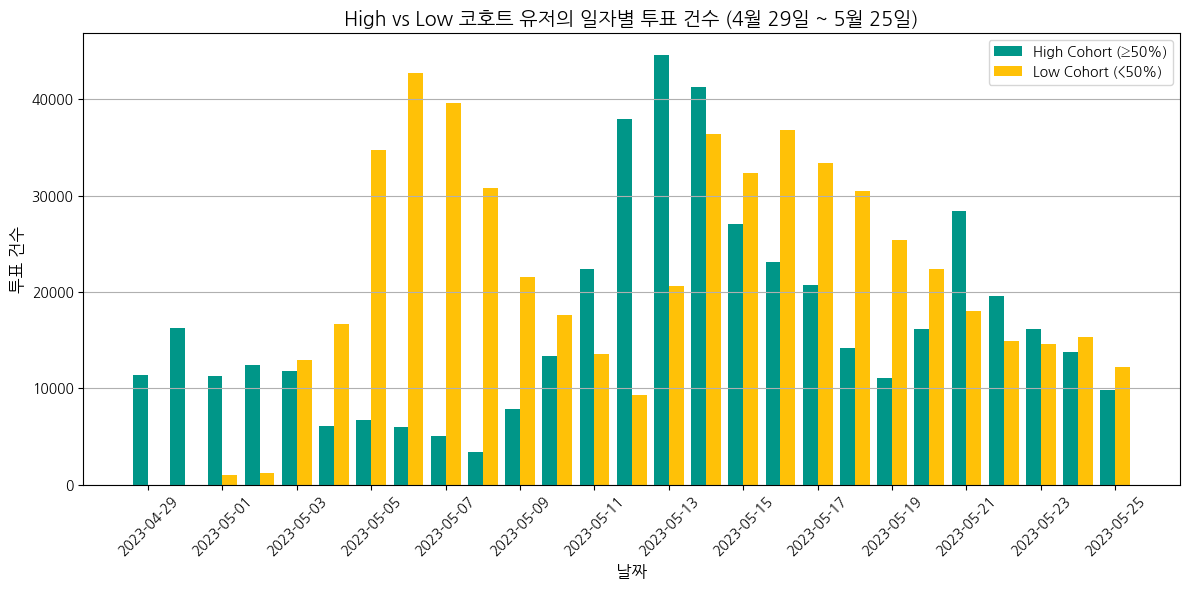

In [67]:
# 필터링: 2023-04-29부터 2023-05-25까지
start_date = pd.to_datetime("2023-04-29").date()
end_date = pd.to_datetime("2023-05-25").date()

range_filtered = daily_comparison[
    (daily_comparison['vote_date'] >= start_date) &
    (daily_comparison['vote_date'] <= end_date)
]

# 바 그래프
plt.figure(figsize=(12, 6))
bar_width = 0.4
dates = range_filtered['vote_date']
x = range(len(dates))

plt.bar([i - bar_width/2 for i in x], range_filtered['high_votes'], width=bar_width, label='High Cohort (≥50%)', color='#009688')
plt.bar([i + bar_width/2 for i in x], range_filtered['low_votes'], width=bar_width, label='Low Cohort (<50%)', color='#ffc107')

plt.title('High vs Low 코호트 유저의 일자별 투표 건수 (4월 29일 ~ 5월 25일)', fontsize=14)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('투표 건수', fontsize=12)
plt.xticks(
    ticks=x[::2],
    labels=[str(d) for d in dates][::2],
    rotation=45
)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### 2. 첫 날 열람 건 수 

In [68]:
# 4/29에 first_vote하고, 그 날 작성한 기록 중 has_read == 1 필터
high_read = votes_with_first[
    (votes_with_first['user_id'].isin(high_users)) &
    (votes_with_first['first_vote_date'] == pd.to_datetime("2023-04-29").date()) &
    (votes_with_first['created_date'] == pd.to_datetime("2023-04-29").date()) &
    (votes_with_first['has_read'] == 1)
]

low_read = votes_with_first[
    (votes_with_first['user_id'].isin(low_users)) &
    (votes_with_first['first_vote_date'] == pd.to_datetime("2023-04-29").date()) &
    (votes_with_first['created_date'] == pd.to_datetime("2023-04-29").date()) &
    (votes_with_first['has_read'] == 1)
]

# 결과 출력
len(high_read), len(low_read)

(466, 0)

In [69]:
high_read

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,vote_date,first_vote,created_date,first_vote_date
3416,821193,C,2023-04-29 01:02:07,849488,139,850866,1067211,1,N,2023-04-29 01:02:07,0,0,2023-04-29,2023-04-29 01:01:05,2023-04-29,2023-04-29
3418,821225,C,2023-04-29 01:02:29,849488,291,850866,1067213,1,N,2023-04-29 01:02:29,0,0,2023-04-29,2023-04-29 01:01:05,2023-04-29,2023-04-29
3419,821241,C,2023-04-29 01:02:38,850344,177,850866,1067214,1,N,2023-04-29 01:02:38,0,0,2023-04-29,2023-04-29 01:01:05,2023-04-29,2023-04-29
3421,821280,C,2023-04-29 01:03:05,849488,187,850866,1067216,1,N,2023-04-29 01:03:05,0,0,2023-04-29,2023-04-29 01:01:05,2023-04-29,2023-04-29
3564,823407,C,2023-04-29 01:27:13,849488,302,850903,1070070,1,N,2023-04-29 01:27:13,0,0,2023-04-29,2023-04-29 01:27:05,2023-04-29,2023-04-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14519,1049176,C,2023-04-29 23:38:36,850269,312,851250,1357412,1,N,2023-04-29 23:38:36,0,0,2023-04-29,2023-04-29 05:09:03,2023-04-29,2023-04-29
14548,1050603,C,2023-04-29 23:50:40,850269,216,851396,1363208,1,N,2023-04-29 23:50:40,0,0,2023-04-29,2023-04-29 05:48:30,2023-04-29,2023-04-29
14550,1050656,I,2023-04-29 23:51:18,849477,122,851396,1363212,1,N,2023-04-29 23:51:18,0,1,2023-04-29,2023-04-29 05:48:30,2023-04-29,2023-04-29
14552,1050704,C,2023-04-29 23:51:49,850098,215,851396,1363216,1,N,2023-04-29 23:51:49,0,0,2023-04-29,2023-04-29 05:48:30,2023-04-29,2023-04-29


In [70]:
csv_path = "/home/eunyu/high_cohort_reads_20230429.csv"
high_read.to_csv(csv_path, index=False)

### 3. 이성에게 받은 투표 수

In [71]:
# ─── 0. 기본 준비 ──────────────────────────────────────────
gender_map = master_df[['user_id', 'gender']]

votes = (
    votes_df
      .merge(gender_map,                                   on='user_id',        how='left')  # 투표자 성별  → gender
      .merge(gender_map.rename(
             columns={'user_id': 'chosen_user_id',
                      'gender':  'chosen_gender'}),
             on='chosen_user_id',                         how='left')           # 피투표자 성별 → chosen_gender
)

high_ids = set(over_df['user_id'])
low_ids  = set(under_df['user_id'])

# ─── 1. 코호트 전체 통계 ───────────────────────────────────
def cohort_stats(id_set: set[str]) -> tuple[int, int, float]:
    rcv = votes[votes['chosen_user_id'].isin(id_set)]
    tot = len(rcv)
    opp = len(rcv[rcv['gender'] != rcv['chosen_gender']])
    return tot, opp, round(opp / tot, 4) if tot else (0, 0, 0.0)

high_total, high_opp, high_ratio = cohort_stats(high_ids)
low_total,  low_opp,  low_ratio  = cohort_stats(low_ids)

print(f"[High] 전체 {high_total:,} · 이성 {high_opp:,} · 비율 {high_ratio:.2%}")
print(f"[Low ] 전체 {low_total :,} · 이성 {low_opp :,} · 비율 {low_ratio :.2%}")

# ─── 2. (선택) 성별 세분화 ─────────────────────────────────
def cohort_gender_stats(id_set: set[str], gender_code: str,
                        cohort_df: pd.DataFrame) -> tuple[int,int,float]:
    gender_ids = set(cohort_df[cohort_df['gender'] == gender_code]['user_id'])
    return cohort_stats(id_set & gender_ids)   # 교집합으로 한 번 더 필터

h_m_total, h_m_opp, h_m_ratio = cohort_gender_stats(high_ids, 'M', over_df)
h_f_total, h_f_opp, h_f_ratio = cohort_gender_stats(high_ids, 'F', over_df)
l_m_total, l_m_opp, l_m_ratio = cohort_gender_stats(low_ids,  'M', under_df)
l_f_total, l_f_opp, l_f_ratio = cohort_gender_stats(low_ids,  'F', under_df)

print(f"High-M  비율 {h_m_ratio:.2%}  | High-F  비율 {h_f_ratio:.2%}")
print(f"Low-M   비율 {l_m_ratio:.2%}  | Low-F   비율 {l_f_ratio:.2%}")


[High] 전체 485,780 · 이성 142,195 · 비율 29.27%
[Low ] 전체 548,185 · 이성 158,734 · 비율 28.96%
High-M  비율 31.82%  | High-F  비율 27.30%
Low-M   비율 29.73%  | Low-F   비율 28.27%


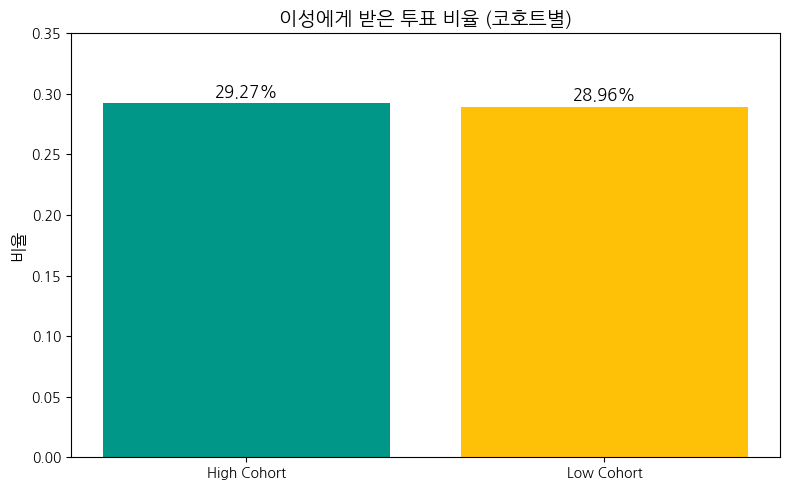

In [72]:
# 전체 집계 비율 (코호트별 전체 투표 수 중 이성에게 받은 비율)
labels = ['High Cohort', 'Low Cohort']
ratios = [0.2927, 0.2896]  # 전체 기반 비율
colors = ['#009688', '#ffc107']

# 막대 그래프
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, ratios, color=colors)
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{ratio:.2%}", ha='center', fontsize=12)

plt.ylim(0, 0.35)
plt.title("이성에게 받은 투표 비율 (코호트별)", fontsize=14)
plt.ylabel("비율", fontsize=12)
plt.tight_layout()
plt.show()

인기/매력 기반의 초기 반응이 리텐션과 상관이 있을 수 있다는 가설

In [73]:

# ───────────────────────────────────────────────
# 1. 성별 정보가 포함된 votes_with_gender 생성
#   - master_df : user_id, gender  포함
#   - votes_df  : user_id(투표자), chosen_user_id(피투표자) 포함
# ───────────────────────────────────────────────
gender_map = master_df[['user_id', 'gender']]

votes_with_gender = (
    votes_df
      .merge(gender_map,                           on='user_id',      how='left')  # 투표자 성별 → gender
      .merge(gender_map.rename(
             columns={'user_id': 'chosen_user_id',
                      'gender':  'chosen_gender'}),
             on='chosen_user_id',                 how='left')         # 피투표자 성별 → chosen_gender
)

# ───────────────────────────────────────────────
# 2. 성별·코호트별 유저 집합
# ───────────────────────────────────────────────
high_male_ids   = over_df.loc[over_df['gender']=='M', 'user_id']
high_female_ids = over_df.loc[over_df['gender']=='F', 'user_id']
low_male_ids    = under_df.loc[under_df['gender']=='M', 'user_id']
low_female_ids  = under_df.loc[under_df['gender']=='F', 'user_id']

# ───────────────────────────────────────────────
# 3. 집합별 이성에게 받은 투표만 필터
# ───────────────────────────────────────────────
def opposite_votes(df, id_series):
    return df[
        (df['chosen_user_id'].isin(id_series)) &
        (df['gender'] != df['chosen_gender'])
    ]

high_male_received   = opposite_votes(votes_with_gender, high_male_ids)
high_female_received = opposite_votes(votes_with_gender, high_female_ids)
low_male_received    = opposite_votes(votes_with_gender, low_male_ids)
low_female_received  = opposite_votes(votes_with_gender, low_female_ids)

# ───────────────────────────────────────────────
# 4. 유저당 평균 이성 투표 수 계산
# ───────────────────────────────────────────────
avg_high_male   = len(high_male_received)   / len(high_male_ids)
avg_high_female = len(high_female_received) / len(high_female_ids)
avg_low_male    = len(low_male_received)    / len(low_male_ids)
avg_low_female  = len(low_female_received)  / len(low_female_ids)

summary = {
    "High Cohort": {
        "남자 유저 수": len(high_male_ids),
        "여자 유저 수": len(high_female_ids),
        "남자 유저당 평균 이성 투표 수": round(avg_high_male,   2),
        "여자 유저당 평균 이성 투표 수": round(avg_high_female, 2)
    },
    "Low Cohort": {
        "남자 유저 수": len(low_male_ids),
        "여자 유저 수": len(low_female_ids),
        "남자 유저당 평균 이성 투표 수": round(avg_low_male,    2),
        "여자 유저당 평균 이성 투표 수": round(avg_low_female,  2)
    }
}

summary


{'High Cohort': {'남자 유저 수': 802,
  '여자 유저 수': 1037,
  '남자 유저당 평균 이성 투표 수': 84.06,
  '여자 유저당 평균 이성 투표 수': 72.11},
 'Low Cohort': {'남자 유저 수': 1368,
  '여자 유저 수': 1496,
  '남자 유저당 평균 이성 투표 수': 56.23,
  '여자 유저당 평균 이성 투표 수': 54.69}}

In [74]:
# ── 1. 성별·코호트별 유저 ID 집합 ──────────────────────────
high_male_ids   = set(over_df.loc[over_df['gender']=='M', 'user_id'])
high_female_ids = set(over_df.loc[over_df['gender']=='F', 'user_id'])
low_male_ids    = set(under_df.loc[under_df['gender']=='M', 'user_id'])
low_female_ids  = set(under_df.loc[under_df['gender']=='F', 'user_id'])

# ── 2. 집합→비율 계산 함수 ────────────────────────────────
def opposite_ratio(receiver_ids: set[str]) -> tuple[int,int,float]:
    """return (전체 받은, 이성 받은, 비율)"""
    r = votes_with_gender[votes_with_gender['chosen_user_id'].isin(receiver_ids)]
    tot = len(r)                                    # 분모: 해당 집단이 받은 전체 투표
    opp = len(r[r['gender'] != r['chosen_gender']]) # 분자: 그중 이성에게 받은 투표
    return tot, opp, round(opp / tot, 4) if tot else (0, 0, 0.0)

# ── 3. 코호트×성별별 계산 ────────────────────────────────
h_m_total, h_m_opp, h_m_ratio = opposite_ratio(high_male_ids)
h_f_total, h_f_opp, h_f_ratio = opposite_ratio(high_female_ids)
l_m_total, l_m_opp, l_m_ratio = opposite_ratio(low_male_ids)
l_f_total, l_f_opp, l_f_ratio = opposite_ratio(low_female_ids)

# ── 4. 결과 정리 ─────────────────────────────────────────
result = {
    "High-Male": {"전체 받은": h_m_total, "이성 받은": h_m_opp, "비율": f"{h_m_ratio:.2%}"},
    "High-Female": {"전체 받은": h_f_total, "이성 받은": h_f_opp, "비율": f"{h_f_ratio:.2%}"},
    "Low-Male":  {"전체 받은": l_m_total, "이성 받은": l_m_opp, "비율": f"{l_m_ratio:.2%}"},
    "Low-Female":{"전체 받은": l_f_total, "이성 받은": l_f_opp, "비율": f"{l_f_ratio:.2%}"}
}

result


{'High-Male': {'전체 받은': 211886, '이성 받은': 67415, '비율': '31.82%'},
 'High-Female': {'전체 받은': 273894, '이성 받은': 74780, '비율': '27.30%'},
 'Low-Male': {'전체 받은': 258757, '이성 받은': 76916, '비율': '29.73%'},
 'Low-Female': {'전체 받은': 289428, '이성 받은': 81818, '비율': '28.27%'}}

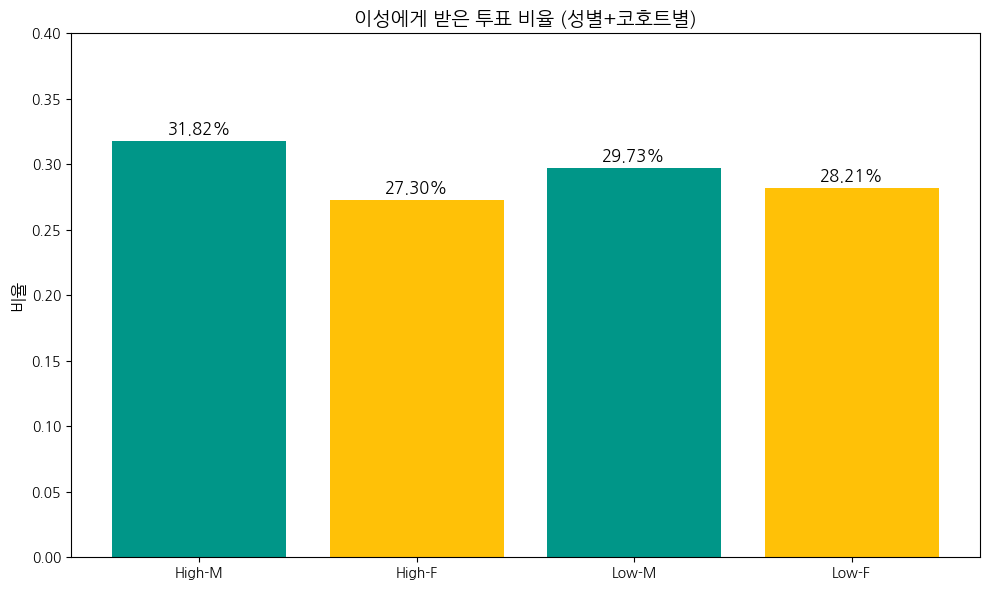

In [75]:

# 집단별 이성 투표 비율 (계산된 값)
ratios = [0.3182, 0.2730, 0.2973, 0.2821]  # High-M, High-F, Low-M, Low-F
labels = ['High-M', 'High-F', 'Low-M', 'Low-F']
colors = ['#009688', '#ffc107', '#009688', '#ffc107']  # 남: 민트, 여: 노랑

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, ratios, color=colors)

# 바 위에 퍼센트 표시
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{ratio:.2%}", ha='center', fontsize=12)

plt.ylim(0, 0.4)
plt.title("이성에게 받은 투표 비율 (성별+코호트별)", fontsize=14)
plt.ylabel("비율", fontsize=12)
plt.tight_layout()
plt.show()


### 컬럼 추가 마스터 테이블 csv

In [41]:
# ─── 0. 기간 필터 적용 ───────────────────────────────
votes_df["created_at"] = pd.to_datetime(votes_df["created_at"])
votes_df = votes_df[
    (votes_df["created_at"] >= "2023-04-28") &
    (votes_df["created_at"] < "2023-08-01")
]


# ─── 1. 성별 정보 매핑 ─────────────────────────────
gender_map = master_df.set_index("user_id")["gender"].to_dict()

# ─── 2. 투표 데이터에 성별 정보 추가 ───────────────
votes_with_gender = (
    votes_df.copy()
    .assign(
        sender_gender=lambda df: df["user_id"].map(gender_map),
        receiver_gender=lambda df: df["chosen_user_id"].map(gender_map)
    )
)

# ─── 3. 전체 받은 투표 수 계산 (피투표자 기준) ─────
total_votes_received = (
    votes_with_gender.groupby("chosen_user_id")
    .size()
    .rename("total_votes_received")
    .reset_index()
    .rename(columns={"chosen_user_id": "user_id"})
)

# ─── 4. 이성에게 받은 투표 수 계산 ────────────────
opposite_votes = votes_with_gender[
    votes_with_gender["sender_gender"] != votes_with_gender["receiver_gender"]
]

opposite_votes_received = (
    opposite_votes.groupby("chosen_user_id")
    .size()
    .rename("opposite_votes_received")
    .reset_index()
    .rename(columns={"chosen_user_id": "user_id"})
)

# ─── 5. master_df에 병합 및 결측값 처리 ───────────
master_df = master_df.merge(total_votes_received, on="user_id", how="left")
master_df = master_df.merge(opposite_votes_received, on="user_id", how="left")

master_df["total_votes_received"] = master_df["total_votes_received"].fillna(0).astype(int)
master_df["opposite_votes_received"] = master_df["opposite_votes_received"].fillna(0).astype(int)

# ─── 6. 비율 컬럼 추가 (0 나눗셈 보호 포함) ───────
master_df["opposite_vote_ratio"] = master_df.apply(
    lambda row: row["opposite_votes_received"] / row["total_votes_received"]
    if row["total_votes_received"] > 0 else 0,
    axis=1
)

# ─── 7. 결과 확인 (선택) ────────────────────────────
master_df[["user_id", "gender", "total_votes_received", "opposite_votes_received", "opposite_vote_ratio"]].head()


,user_id,gender,total_votes_received,opposite_votes_received,opposite_vote_ratio
0,838023,F,262,33,0.125954
1,838466,F,342,46,0.134503
2,838642,F,40,4,0.100000
3,839357,M,173,138,0.797688
4,840293,F,241,50,0.207469


In [47]:
print(votes_df["created_at"].min())
print(votes_df["created_at"].max())


2023-04-28 12:27:49
2023-07-31 23:43:10


In [42]:
# 저장할 컬럼 정의
export_cols = [
    "user_id", "gender", "total_votes_received",
    "opposite_votes_received", "opposite_vote_ratio"
]

# CSV로 저장
master_df[export_cols].to_csv("master_with_vote_stats.csv", index=False)

In [43]:
# 저장할 컬럼 정의
export_cols = [
    "user_id", "gender", "school_id", "grade",
    "total_votes_received", "opposite_votes_received", "opposite_vote_ratio"
]

# CSV 저장
master_df[export_cols].to_csv("master_with_vote_stats_extended.csv", index=False)


In [44]:
master_df_3 = pd.read_csv('/home/eunyu/분석코드/master_with_vote_stats_extended.csv')
master_df_3.head()

,user_id,gender,school_id,grade,total_votes_received,opposite_votes_received,opposite_vote_ratio
0,838023,F,271.0,1.0,262,33,0.125954
1,838466,F,369.0,2.0,342,46,0.134503
2,838642,F,271.0,2.0,40,4,0.100000
3,839357,M,271.0,1.0,173,138,0.797688
4,840293,F,369.0,1.0,241,50,0.207469


In [45]:
# 1. 동성에게 받은 투표 필터링
same_gender_votes = votes_with_gender[
    votes_with_gender["sender_gender"] == votes_with_gender["receiver_gender"]
]

# 2. 유저별 집계 (피투표자 기준)
same_gender_counts = (
    same_gender_votes.groupby("chosen_user_id")
    .size()
    .rename("same_gender_votes_received")
    .reset_index()
    .rename(columns={"chosen_user_id": "user_id"})
)

# 3. master_df에 병합
master_df = master_df.merge(same_gender_counts, on="user_id", how="left")
master_df["same_gender_votes_received"] = (
    master_df["same_gender_votes_received"].fillna(0).astype(int)
)

# 4. 컬럼 확인 (선택)
master_df[[
    "user_id", "gender", "school_id", "grade", "total_votes_received",
    "opposite_votes_received", "same_gender_votes_received", "opposite_vote_ratio"
]].head()


,user_id,gender,school_id,grade,total_votes_received,opposite_votes_received,same_gender_votes_received,opposite_vote_ratio
0,838023,F,271.0,1.0,262,33,229,0.125954
1,838466,F,369.0,2.0,342,46,296,0.134503
2,838642,F,271.0,2.0,40,4,36,0.100000
3,839357,M,271.0,1.0,173,138,35,0.797688
4,840293,F,369.0,1.0,241,50,191,0.207469


In [46]:
master_df.to_csv("master_with_all.csv", index=False)

#### 각 유저가 자신의 코호트 첫날에 이성에게 받은 투표 수 계산

In [82]:
first_vote_map = (
    votes_df.groupby('user_id')['created_at']
    .min()
    .reset_index()
    .rename(columns={'user_id': 'chosen_user_id', 'created_at': 'first_vote'})
)


In [83]:
votes_gendered = (
    votes_df
    .merge(master_df[['user_id', 'gender']], on='user_id', how='left')  # 투표자 성별
    .merge(master_df[['user_id', 'gender']].rename(columns={'user_id': 'chosen_user_id', 'gender': 'chosen_gender'}),
           on='chosen_user_id', how='left')  # 피투표자 성별
    .merge(first_vote_map, on='chosen_user_id', how='left')  # 피투표자의 first_vote
)
votes_gendered['created_at'] = pd.to_datetime(votes_gendered['created_at'])
votes_gendered['first_vote'] = pd.to_datetime(votes_gendered['first_vote'])


In [84]:
first_day_opposite = votes_gendered[
    (votes_gendered['gender'] != votes_gendered['chosen_gender']) &  # 이성
    (votes_gendered['created_at'].dt.date == votes_gendered['first_vote'].dt.date)  # 첫날
]


In [85]:
first_day_counts = (
    first_day_opposite.groupby('chosen_user_id')
    .size()
    .reset_index(name='first_day_opposite_votes')
)


In [86]:
over_df = over_df.copy()
under_df = under_df.copy()

over_df['retention_group'] = 'high'
under_df['retention_group'] = 'low'
user_stats = pd.concat([over_df, under_df], ignore_index=True)


In [87]:
user_stats = user_stats.merge(first_day_counts, left_on='user_id', right_on='chosen_user_id', how='left')
user_stats['first_day_opposite_votes'] = user_stats['first_day_opposite_votes'].fillna(0).astype(int)


In [88]:
user_stats

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,ret_group_under,gender,group_id,school_id,grade,retention_group,chosen_user_id,first_day_opposite_votes
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상,50 이상,None,F,233.0,271.0,1.0,high,838023.0,3
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,50 이상,None,F,321.0,369.0,2.0,high,NaN,0
2,838642,1,1,2023-04-29,2023-04-29,0,2023-04-29,0.515152,50 이상,50 이상,None,F,356.0,271.0,2.0,high,838642.0,1
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.515152,50 이상,50 이상,None,M,519.0,271.0,1.0,high,839357.0,3
4,840512,131,7,2023-05-02,2023-05-16,14,2023-05-02,0.569444,50 이상,50 이상,None,M,930.0,369.0,1.0,high,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,M,73885.0,4426.0,2.0,low,NaN,0
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,F,29558.0,5520.0,2.0,low,NaN,0
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,F,72313.0,4426.0,2.0,low,NaN,0
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,F,72313.0,4426.0,2.0,low,NaN,0


## 가설
### 이성에게 받은 초기 반응(투표 수)이 높을수록 리텐션이 높을 것이다.

#### 1. 이성에게 7건 이상 투표를 받은 유저는 8일차 리텐션이 50% 이상일 확률이 높다.

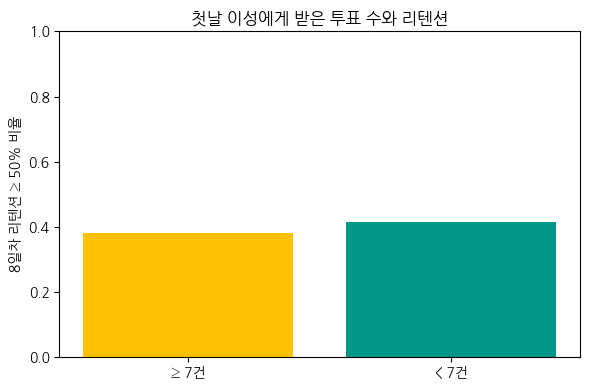

,above_7,Retention ≥ 50% 비율
0,False,0.381661
1,True,0.414435


In [66]:
# 성별 병합
gender_map = master_df[['user_id', 'gender']]
votes = (
    votes_df
    .merge(gender_map, on='user_id', how='left')
    .merge(gender_map.rename(columns={'user_id': 'chosen_user_id', 'gender': 'chosen_gender'}), on='chosen_user_id', how='left')
)

# 유저별 첫 투표일 계산
first_vote_df = votes.groupby('chosen_user_id')['created_at'].min().reset_index(name='first_vote')
votes = votes.merge(first_vote_df, on='chosen_user_id', how='left')
votes['first_day'] = votes['first_vote'].dt.date
votes['vote_day'] = votes['created_at'].dt.date

# 첫날 이성에게 받은 투표 필터링
first_day_opposite_votes = votes[
    (votes['vote_day'] == votes['first_day']) &
    (votes['gender'] != votes['chosen_gender'])
]

# 유저별 첫날 이성 투표 수
first_day_counts = (
    first_day_opposite_votes
    .groupby('chosen_user_id')
    .size()
    .reset_index(name='first_day_opposite_votes')
)

# 리텐션 정보 병합
user_ret = master_df[['user_id', 'retention_day8']]
user_ret = user_ret.merge(first_day_counts, left_on='user_id', right_on='chosen_user_id', how='left')
user_ret['first_day_opposite_votes'] = user_ret['first_day_opposite_votes'].fillna(0)

# 가설 1: 7건 이상 vs 미만
user_ret['above_7'] = user_ret['first_day_opposite_votes'] >= 7

# 각 그룹의 8일차 리텐션 ≥ 50% 비율
result = (
    user_ret.groupby('above_7')['retention_day8']
    .apply(lambda x: (x >= 0.5).mean())
    .reset_index(name='Retention ≥ 50% 비율')
)

# 시각화
plt.figure(figsize=(6, 4))
colors = ['#ffc107', '#009688']
plt.bar(['≥ 7건', '< 7건'], result['Retention ≥ 50% 비율'], color=colors)
plt.ylabel('8일차 리텐션 ≥ 50% 비율')
plt.title('첫날 이성에게 받은 투표 수와 리텐션')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

result

- 7건 이상 받은 유저 그룹이 실제로 더 높은 리텐션율을 보임
   - +3.3%p 상승 (41.4% vs 38.2%)
- 단, 두 그룹 모두 절대값이 50%를 넘지는 않음.

In [67]:

# 성별 정보
user_gender = master_df[['user_id', 'gender']]

# 투표자와 피투표자의 성별 정보 병합
votes_df = votes_df.merge(user_gender.rename(columns={'user_id': 'user_id', 'gender': 'voter_gender'}),
                          on='user_id', how='left')
votes_df = votes_df.merge(user_gender.rename(columns={'user_id': 'chosen_user_id', 'gender': 'chosen_gender'}),
                          on='chosen_user_id', how='left')

# 이성에게 받은 투표만 필터링
votes_opposite = votes_df[votes_df['voter_gender'] != votes_df['chosen_gender']]

# 유저별 이성에게 받은 투표 수 집계
opposite_received = (
    votes_opposite
    .groupby('chosen_user_id')
    .size()
    .reset_index(name='opposite_votes')
    .rename(columns={'chosen_user_id': 'user_id'})
)

# 마스터와 병합하여 리텐션 정보 포함
merged = master_df.merge(opposite_received, on='user_id', how='left')
merged['opposite_votes'] = merged['opposite_votes'].fillna(0)

# 리텐션 여부 및 투표 그룹 생성
merged['is_high_retention'] = merged['retention_day8'] >= 0.5
merged['vote_group'] = merged['opposite_votes'] >= 7

# 교차표 생성
contingency = pd.crosstab(merged['vote_group'], merged['is_high_retention'])
contingency



is_high_retention,False,True
vote_group,,
False,375,113
True,2489,1726


In [68]:
import numpy as np
from math import exp

# 관측값
observed = np.array([
    [375, 113],    # 7건 미만
    [2489, 1726]   # 7건 이상
])

# 행합, 열합, 전체합
row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
total = observed.sum()

# 기대값 계산
expected = np.outer(row_totals, col_totals) / total

# 카이제곱 통계량 계산
chi2_stat = ((observed - expected) ** 2 / expected).sum()

# 자유도 계산
dof = (observed.shape[0] - 1) * (observed.shape[1] - 1)

# 자유도 1 기준 근사 p-value 계산
p_approx = exp(-0.5 * chi2_stat)

# 결과 정리
chi2_result = {
    "카이제곱 통계량": round(chi2_stat, 3),
    "자유도": dof,
    "p-value (근사)": round(p_approx, 5)
}

chi2_result


{'카이제곱 통계량': 58.15, '자유도': 1, 'p-value (근사)': 0.0}

유의수준 0.05에서 p-value가 매우 작기 때문에,                 
"이성에게 7건 이상 투표를 받은 유저는 8일차 리텐션이 높다"는 가설을 통계적으로 유의하게 지지한다.            
즉, 이성에게 받은 투표 수가 많을수록 실제로 리텐션이 높을 가능성이 크다.          

#### 2. 첫날 이성에게 받은 투표 수가 3건 이상이면, 8일차까지 잔존할 확률이 유의하게 높다

In [69]:
import numpy as np
import math

# NaN → 0으로 처리
user_stats["first_day_opposite_votes"] = user_stats["first_day_opposite_votes"].fillna(0).astype(int)

# 그룹 분류
user_stats["vote_group"] = np.where(user_stats["first_day_opposite_votes"] >= 3, "3+ votes", "<3 votes")

# 그룹별 리텐션 요약
group_summary = (
    user_stats.groupby("vote_group")["retention_day8"]
    .agg(["sum", "count", "mean"])
    .rename(columns={"sum": "retained_users", "count": "total_users", "mean": "retention_rate"})
    .reset_index()
)

# z-test 함수
def proportion_ztest(successes, samples):
    p1, p2 = successes / samples
    p_comb = successes.sum() / samples.sum()
    se = math.sqrt(p_comb * (1 - p_comb) * (1/samples[0] + 1/samples[1]))
    z = (p1 - p2) / se
    p_value_one = 0.5 * math.erfc(z / math.sqrt(2))
    p_value_two = p_value_one * 2
    return z, p_value_one, p_value_two

# 검정 실행
successes = np.array(group_summary["retained_users"])
samples = np.array(group_summary["total_users"])
z_stat, p_val_one, p_val_two = proportion_ztest(successes, samples)

# 결과 출력
print("=== 그룹별 리텐션 요약 ===")
print(group_summary)
print("\n=== 비율 차이 검정 결과 ===")
print(f"Z-statistic           : {z_stat:.3f}")
print(f"P-value (단측, 3+ > <3) : {p_val_one:.4f}")
print(f"P-value (양측)         : {p_val_two:.4f}")


=== 그룹별 리텐션 요약 ===
  vote_group  retained_users  total_users  retention_rate
0   3+ votes     1173.585338         2554        0.459509
1   <3 votes      974.700012         2149        0.453560

=== 비율 차이 검정 결과 ===
Z-statistic           : 0.408
P-value (단측, 3+ > <3) : 0.3416
P-value (양측)         : 0.6833


결론: 귀무가설 기각 실패
- 단측 검정 p-value = 0.3416 > 0.05          
→ 귀무가설을 기각할 수 없다.
- 3건 이상 받은 그룹이 더 높은 리텐션율을 보인다고 통계적으로 확신할 수 없음
- 첫날 이성에게 받은 투표 수가 3건 이상이면 8일차까지 잔존할 확률이 유의하게 높다”는 통계적으로 유의하지 않다.

### 4. 소속 학교, 학년, 성별

In [70]:
# High/Low 코호트 분리
over_df = user_stats[user_stats["retention_day8"] >= 0.5].copy()
under_df = user_stats[user_stats["retention_day8"] < 0.5].copy()

# 비율 분포 함수
def get_distribution(df, col):
    return df[col].value_counts(normalize=True).rename("rate").reset_index().rename(columns={"index": col})

# 각 변수별 분포 계산
gender_over = get_distribution(over_df, "gender")
gender_under = get_distribution(under_df, "gender")

school_over = get_distribution(over_df, "school_id")
school_under = get_distribution(under_df, "school_id")

grade_over = get_distribution(over_df, "grade")
grade_under = get_distribution(under_df, "grade")

# 보기 쉽게 정리
print("성별 분포 비교:")
display(pd.merge(gender_over, gender_under, on="gender", how="outer", suffixes=("_over", "_under")))

print("학년 분포 비교:")
display(pd.merge(grade_over, grade_under, on="grade", how="outer", suffixes=("_over", "_under")))

print("학교 분포 비교:")
display(pd.merge(school_over, school_under, on="school_id", how="outer", suffixes=("_over", "_under")))


성별 분포 비교:


,gender,rate_over,rate_under
0,F,0.563893,0.522346
1,M,0.436107,0.477654


학년 분포 비교:


,grade,rate_over,rate_under
0,2.0,0.432300,0.414455
1,1.0,0.371397,0.347765
2,3.0,0.196302,0.237779


학교 분포 비교:


,school_id,rate_over,rate_under
0,271.0,0.196302,0.034567
1,5520.0,0.178358,0.044693
2,5491.0,0.158238,0.057263
3,5372.0,0.139750,0.076466
4,1478.0,0.128331,0.072975
5,4426.0,0.116911,0.077514
6,4516.0,0.033170,0.133031
7,369.0,0.025557,0.170391
8,352.0,0.015769,0.150140
9,1719.0,0.007613,0.182961


- High 코호트에서는 여성 비중이 더 큼             
→ 여성 유저일수록 8일차까지 잔존할 확률이 다소 높을 수 있음

- High 코호트는 3학년 비중이 낮고, 1·2학년 비중이 상대적으로 높음         
→ 고학년일수록 잔존률이 낮을 가능성이 있음

- 특정 학교(예: 271, 5520, 5491)의 유저는 High 코호트에 많이 분포
- 반대로, school_id 1719는 Low 코호트 비중이 매우 높음 (18.3%) → 해당 학교는 리텐션이 낮은 중심

In [71]:

# first_day_opposite_votes를 다시 채워줌 (임시로 0으로 가정, 분석 목적 아님)
master_df["first_day_opposite_votes"] = 0
user_stats = master_df.copy()

# High/Low 코호트 분리
over_df = user_stats[user_stats["retention_day8"] >= 0.5].copy()
under_df = user_stats[user_stats["retention_day8"] < 0.5].copy()

# 유저 수 요약 함수
def get_counts(df, col):
    return df[col].value_counts().rename("count").reset_index().rename(columns={"index": col})

# 성별, 학년, 학교별 유저 수
gender_over = get_counts(over_df, "gender")
gender_under = get_counts(under_df, "gender")

grade_over = get_counts(over_df, "grade")
grade_under = get_counts(under_df, "grade")

school_over = get_counts(over_df, "school_id")
school_under = get_counts(under_df, "school_id")

# 보기 쉽게 정리
gender_compare = pd.merge(gender_over, gender_under, on="gender", how="outer", suffixes=("_over", "_under"))
grade_compare = pd.merge(grade_over, grade_under, on="grade", how="outer", suffixes=("_over", "_under"))
school_compare = pd.merge(school_over, school_under, on="school_id", how="outer", suffixes=("_over", "_under"))

gender_compare, grade_compare, school_compare.head(10)


(  gender  count_over  count_under
 0      F        1037         1496
 1      M         802         1368,
    grade  count_over  count_under
 0    2.0         795         1187
 1    1.0         683          996
 2    3.0         361          681,
    school_id  count_over  count_under
 0      271.0         361           99
 1     5520.0         328          128
 2     5491.0         291          164
 3     5372.0         257          219
 4     1478.0         236          209
 5     4426.0         215          222
 6     4516.0          61          381
 7      369.0          47          488
 8      352.0          29          430
 9     1719.0          14          524)

- 여성 유저가 High 코호트에서 더 많음, 반면 Low 코호트에서는 남성 유저 비중이 상대적으로 큼
- 전반적으로 모든 학년에서 Low 코호트 유저 수가 더 많음, 하지만 비율상 고학년일수록 잔존률이 낮아지는 패턴 존재
- 일부 학교(예: 271, 5520)는 High 코호트에서 강세, 반면 school_id=1719, 369, 352 등은 Low 코호트 비중이 압도적으로 높음 → 학교별 리텐션 차이가 뚜렷

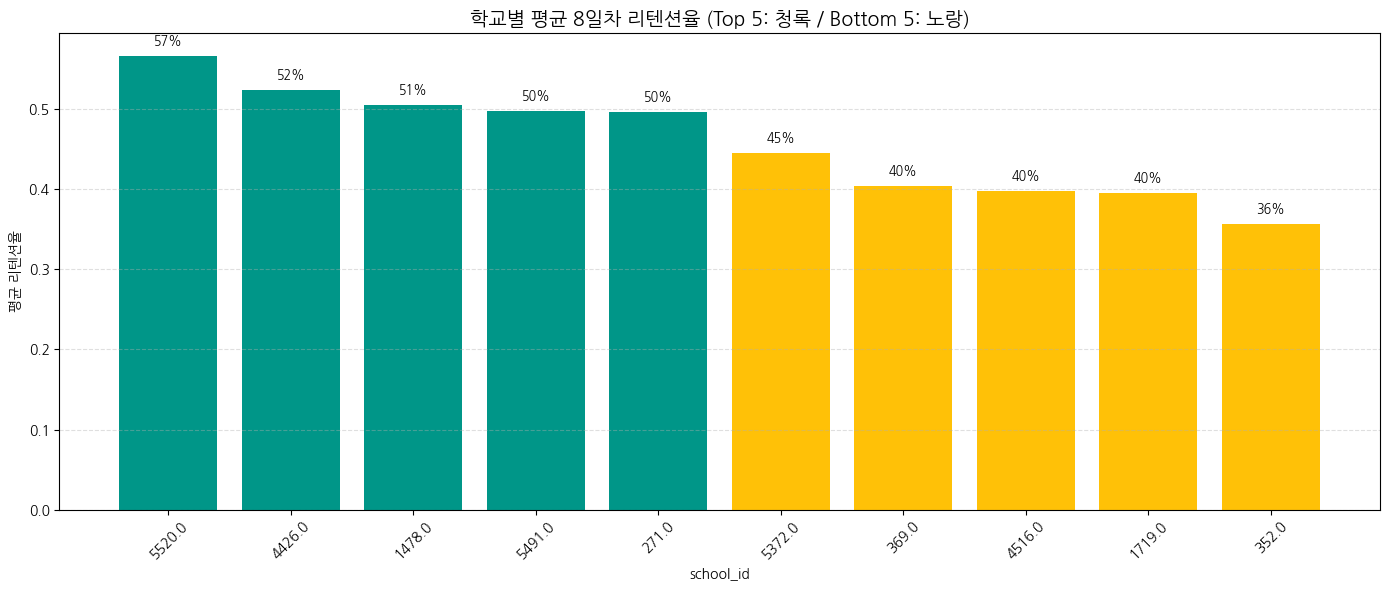

In [72]:
import matplotlib.pyplot as plt

# 1) 평균 리텐션율 계산
school_ret = (
    user_stats.groupby("school_id")["retention_day8"]
    .mean()
    .reset_index()
    .sort_values("retention_day8", ascending=False)
)

# 2) 색상 지정
school_ret_sorted = school_ret.reset_index(drop=True)
colors = []
for i in range(len(school_ret_sorted)):
    if i < 5:
        colors.append("#009688")  # 상위
    elif i >= len(school_ret_sorted) - 5:
        colors.append("#ffc107")  # 하위
    else:
        colors.append("lightgray")

# 3) 시각화
plt.figure(figsize=(14, 6))
bars = plt.bar(
    school_ret_sorted["school_id"].astype(str),
    school_ret_sorted["retention_day8"],
    color=colors
)

# 4) 값 표시 (% 단위로 표시)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,  # 막대 위 여백
        f"{height:.0%}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title("학교별 평균 8일차 리텐션율 (Top 5: 청록 / Bottom 5: 노랑)", fontsize=14)
plt.xlabel("school_id")
plt.ylabel("평균 리텐션율")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [73]:
# 학교별 리텐션 요약 통계: 평균, 중앙값, 표준편차, 유저 수
school_ret_summary = (
    user_stats.groupby("school_id")["retention_day8"]
    .agg(count="count", mean="mean", median="median", std="std")
    .reset_index()
    .sort_values("mean", ascending=False)
)

school_ret_summary


,school_id,count,mean,median,std
9,5520.0,456,0.566455,0.544974,0.136282
5,4426.0,437,0.524000,0.452555,0.137500
3,1478.0,445,0.505391,0.509589,0.090786
8,5491.0,455,0.498041,0.509589,0.122858
0,271.0,460,0.496838,0.515152,0.059621
7,5372.0,476,0.445706,0.509589,0.101370
2,369.0,535,0.404645,0.422977,0.081813
6,4516.0,442,0.398329,0.390476,0.096734
4,1719.0,538,0.395004,0.416667,0.093443
1,352.0,459,0.356702,0.316514,0.086614


<Axes: title={'center': '학교별 High 코호트 비율 (8일차 리텐션 ≥ 50%)'}, xlabel='school_id'>

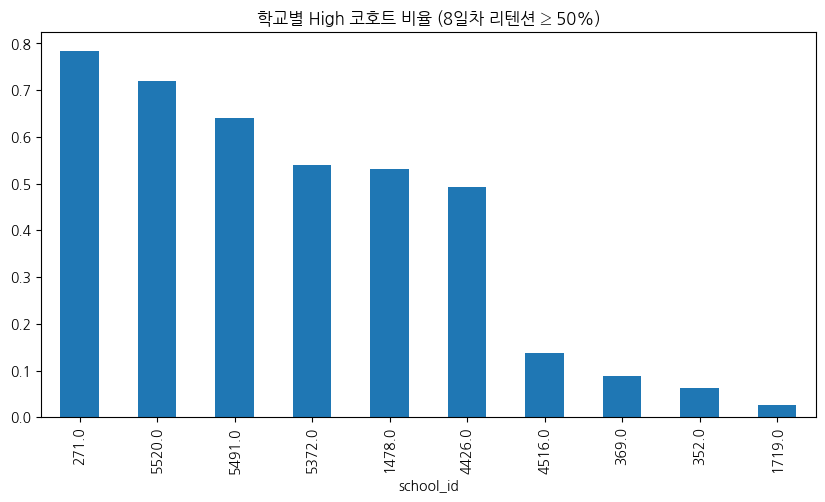

In [74]:
user_stats["ret_group"] = np.where(user_stats["retention_day8"] >= 0.5, "High", "Low")
school_cohort_dist = (
    user_stats.groupby(["school_id", "ret_group"])["user_id"]
    .count()
    .unstack(fill_value=0)
)

# 비율 계산
school_cohort_dist["High_ratio"] = school_cohort_dist["High"] / (school_cohort_dist["High"] + school_cohort_dist["Low"])
school_cohort_dist = school_cohort_dist.sort_values("High_ratio", ascending=False)

# 상위 10개 시각화
school_cohort_dist["High_ratio"].head(10).plot(kind="bar", figsize=(10, 5), title="학교별 High 코호트 비율 (8일차 리텐션 ≥ 50%)")


In [75]:
# retention_day8 기준으로 High / Low 구분
user_stats["ret_group"] = user_stats["retention_day8"].apply(lambda x: "High" if x >= 0.5 else "Low")

# 학교별 High/Low 유저 수 카운트
school_cohort_dist = (
    user_stats.groupby(["school_id", "ret_group"])["user_id"]
    .count()
    .unstack(fill_value=0)
)

# 전체 대비 비율 계산
school_cohort_dist["High_ratio"] = school_cohort_dist["High"] / (school_cohort_dist["High"] + school_cohort_dist["Low"])
school_cohort_dist["Low_ratio"] = school_cohort_dist["Low"] / (school_cohort_dist["High"] + school_cohort_dist["Low"])

# 정렬 및 미리보기
school_cohort_dist_sorted = school_cohort_dist.sort_values("High_ratio", ascending=False).reset_index()
school_cohort_dist_sorted[["school_id", "High_ratio", "Low_ratio"]].head(10)


ret_group,school_id,High_ratio,Low_ratio
0,271.0,0.784783,0.215217
1,5520.0,0.719298,0.280702
2,5491.0,0.639560,0.360440
3,5372.0,0.539916,0.460084
4,1478.0,0.530337,0.469663
5,4426.0,0.491991,0.508009
6,4516.0,0.138009,0.861991
7,369.0,0.087850,0.912150
8,352.0,0.063181,0.936819
9,1719.0,0.026022,0.973978


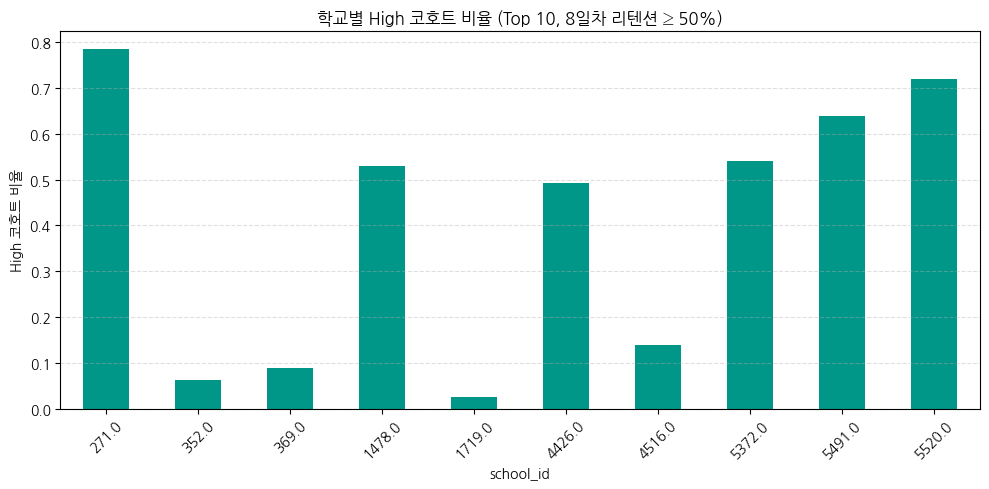

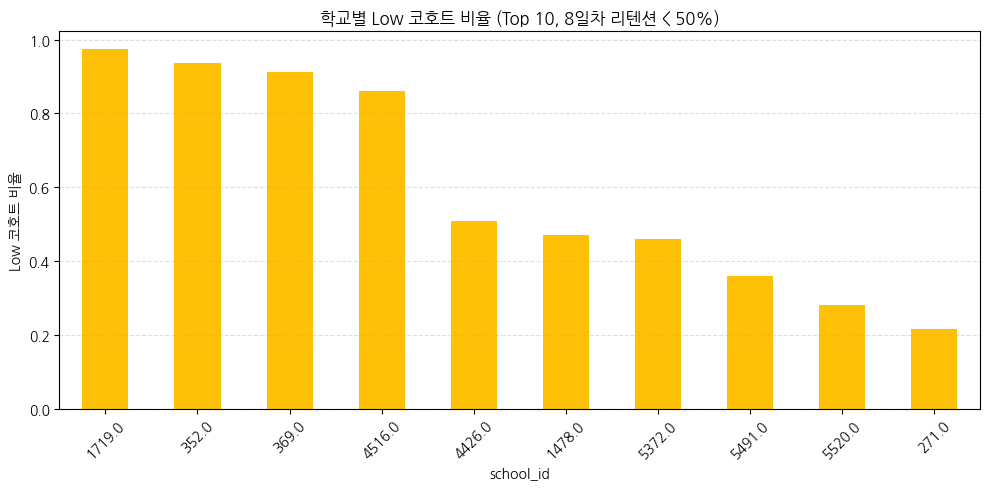

In [76]:
import matplotlib.pyplot as plt

# 상위 10개 학교 - High 코호트 비율 시각화
plt.figure(figsize=(10, 5))
school_cohort_dist["High_ratio"].head(10).plot(
    kind="bar",
    color="#009688",
    title="학교별 High 코호트 비율 (Top 10, 8일차 리텐션 ≥ 50%)"
)
plt.ylabel("High 코호트 비율")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 하위 10개 학교 - Low 코호트 비율 시각화
plt.figure(figsize=(10, 5))
school_cohort_dist["Low_ratio"] = 1 - school_cohort_dist["High_ratio"]  # 또는 동일한 로직
school_cohort_dist["Low_ratio"].sort_values(ascending=False).head(10).plot(
    kind="bar",
    color="#ffc107",
    title="학교별 Low 코호트 비율 (Top 10, 8일차 리텐션 < 50%)"
)
plt.ylabel("Low 코호트 비율")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


---

---

# 상위 하위 25% 지표 변경

In [3]:


# 파일 경로 
file1 = "/home/eunyu/master-v1 (1).csv"
file2 = "/home/eunyu/master_with_all_vote_stats.csv"
file3 = "/home/eunyu/integrated_master_table (1).csv"

# CSV 불러오기
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

# user_id 기준 병합
merged_df = df1.merge(df2, on="user_id", how="outer", suffixes=('_v1', '_votes'))
merged_df = merged_df.merge(df3, on="user_id", how="outer")

# 병합 결과 
merged_df.head()


,user_id,total_votes_v1,unique_days_v1,first_vote_v1,last_vote_v1,active_days_v1,cohort_day_v1,retention_day8_v1,ret_group_v1,ret_group_over_v1,...,opposite_sex_vote_received_ratio,candidate_count,chosen_count,ratio,address,student_count,school_type,firstquestion_id,first_question_text,first_question_category
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상,50 이상,...,0.125954,27.0,10.0,0.370370,충청남도 천안시 서북구,491,H,121,가장 어른스러운 사람은?,['심리' '성격' '인간관계']
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,50 이상,...,0.134111,82.0,37.0,0.451220,충청남도 아산시,578,H,298,옷이 제일 많을 거 같은 사람은?,['일상' '스타일' '관찰']
2,838642,1,1,2023-04-29,2023-04-29,0,2023-04-29,0.515152,50 이상,50 이상,...,0.100000,44.0,5.0,0.113636,충청남도 천안시 서북구,491,H,161,화목한 가정을 꾸릴거 같은 사람은?,['일상' '라이프스타일' '인간관계']
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.515152,50 이상,50 이상,...,0.797688,42.0,10.0,0.238095,충청남도 천안시 서북구,491,H,179,책을 제일 많이 읽은 것 같은 사람은?,['일상' '지식' '관찰']
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만,NaN,...,0.207469,74.0,31.0,0.418919,충청남도 아산시,578,H,464,뭔가 제대로 한 번 보여줄 것 같은 사람은?,['성격' '미래' '관찰']


In [ ]:

# 병합 결과 저장
merged_df.to_csv("merged_master_table.csv", index=False)

In [4]:
merged_master_df = pd.read_csv('/home/eunyu/merged_master_table.csv')
merged_master_df

,user_id,total_votes_v1,unique_days_v1,first_vote_v1,last_vote_v1,active_days_v1,cohort_day_v1,retention_day8_v1,ret_group_v1,ret_group_over_v1,...,opposite_sex_vote_received_ratio,candidate_count,chosen_count,ratio,address,student_count,school_type,firstquestion_id,first_question_text,first_question_category
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상,50 이상,...,0.125954,27.0,10.0,0.370370,충청남도 천안시 서북구,491,H,121,가장 어른스러운 사람은?,['심리' '성격' '인간관계']
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,50 이상,...,0.134111,82.0,37.0,0.451220,충청남도 아산시,578,H,298,옷이 제일 많을 거 같은 사람은?,['일상' '스타일' '관찰']
2,838642,1,1,2023-04-29,2023-04-29,0,2023-04-29,0.515152,50 이상,50 이상,...,0.100000,44.0,5.0,0.113636,충청남도 천안시 서북구,491,H,161,화목한 가정을 꾸릴거 같은 사람은?,['일상' '라이프스타일' '인간관계']
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.515152,50 이상,50 이상,...,0.797688,42.0,10.0,0.238095,충청남도 천안시 서북구,491,H,179,책을 제일 많이 읽은 것 같은 사람은?,['일상' '지식' '관찰']
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만,NaN,...,0.207469,74.0,31.0,0.418919,충청남도 아산시,578,H,464,뭔가 제대로 한 번 보여줄 것 같은 사람은?,['성격' '미래' '관찰']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,NaN,...,0.270270,NaN,NaN,NaN,경상남도 거제시,483,H,504,얘랑 있으면 시간이 너무 빨리가는것 같아,['일상' '감성' '인간관계']
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,NaN,...,0.583893,NaN,NaN,NaN,경기도 광명시,500,M,1576,죽기 전에 마지막으로 대화하고 싶은 사람은?,['미래' '대화' '인간관계']
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,NaN,...,0.196078,NaN,NaN,NaN,경상남도 거제시,483,H,604,부모님한테 가장 잘할 것 같은 친구는?,['심리' '일상' '인간관계']
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,NaN,...,0.333333,NaN,NaN,NaN,경상남도 거제시,483,H,1532,이 사람의 발냄새 만큼은 용서 된다,['일상' '감성' '인간관계']


## 1. 이성에게 받은 투표 수

In [5]:
# 1. 코호트 구분: retention_day8 상위·하위 25 %

# retention_day8이 숫자로 안전하게 처리되었는지 먼저 확인
merged_master_df["retention_day8"] = pd.to_numeric(merged_master_df["retention_day8"], errors="coerce")

# 분위수 기준 계산
q25 = merged_master_df["retention_day8"].quantile(0.25)
q75 = merged_master_df["retention_day8"].quantile(0.75)

# 하위 25% 유저 (Low Cohort)
cohort_low_df  = merged_master_df[merged_master_df["retention_day8"] <= q25]

# 상위 25% 유저 (High Cohort)
cohort_high_df = merged_master_df[merged_master_df["retention_day8"] >= q75]

# 유저 ID 추출
low_ids  = set(cohort_low_df["user_id"])
high_ids = set(cohort_high_df["user_id"])


In [6]:
# 2. 전체·이성 투표 수 집계 (이미 계산된 컬럼 사용)
# ─────────────────────────────────────────────
def cohort_stats(df: pd.DataFrame) -> tuple[int, int, float]:
    total_votes = df["total_votes_received"].sum()
    opp_votes   = df["opposite_votes_received"].sum()
    ratio       = round(opp_votes / total_votes, 4) if total_votes else 0.0
    return total_votes, opp_votes, ratio

high_total, high_opp, high_ratio = cohort_stats(cohort_high_df)
low_total,  low_opp,  low_ratio  = cohort_stats(cohort_low_df)

print(f"[High] 전체 {high_total:,} · 이성 {high_opp:,} · 비율 {high_ratio:.2%}")
print(f"[Low ] 전체 {low_total :,} · 이성 {low_opp :,} · 비율 {low_ratio :.2%}")

# ─────────────────────────────────────────────
# 3. 성별 세분화 집계
# ─────────────────────────────────────────────
def gender_cohort_stats(df: pd.DataFrame, gender_code: str):
    return cohort_stats(df[df["gender"] == gender_code])

h_m_total, h_m_opp, h_m_ratio = gender_cohort_stats(cohort_high_df, "M")
h_f_total, h_f_opp, h_f_ratio = gender_cohort_stats(cohort_high_df, "F")
l_m_total, l_m_opp, l_m_ratio = gender_cohort_stats(cohort_low_df,  "M")
l_f_total, l_f_opp, l_f_ratio = gender_cohort_stats(cohort_low_df,  "F")

print(f"High-M  비율 {h_m_ratio:.2%} | High-F  비율 {h_f_ratio:.2%}")
print(f"Low-M   비율 {l_m_ratio:.2%} | Low-F   비율 {l_f_ratio:.2%}")

[High] 전체 327,702 · 이성 95,627 · 비율 29.18%
[Low ] 전체 203,169 · 이성 59,439 · 비율 29.26%
High-M  비율 31.87% | High-F  비율 26.99%
Low-M   비율 29.43% | Low-F   비율 29.09%


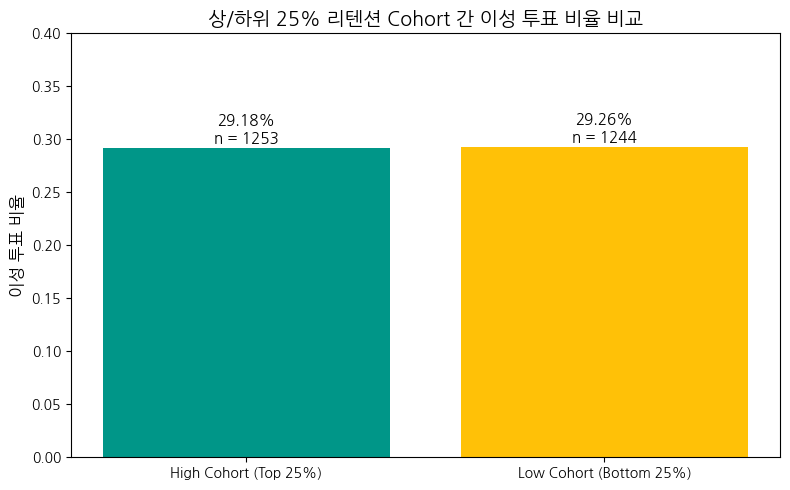

In [7]:
#  이성 투표 비율(전체 기준)

# 코호트별 유저 수
n_high = len(cohort_high_df)
n_low = len(cohort_low_df)

# 시각화
import matplotlib.pyplot as plt

labels = ['High Cohort (Top 25%)', 'Low Cohort (Bottom 25%)']
ratios = [high_ratio, low_ratio]
user_counts = [n_high, n_low]
colors = ['#009688', '#ffc107']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, ratios, color=colors)

# 비율 + 유저 수 함께 표시
for bar, ratio, n in zip(bars, ratios, user_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{ratio:.2%}\nn = {n}", ha='center', fontsize=11)

plt.ylim(0, 0.4)
plt.ylabel("이성 투표 비율", fontsize=12)
plt.title("상/하위 25% 리텐션 Cohort 간 이성 투표 비율 비교", fontsize=14)
plt.tight_layout()
plt.show()


- 상위 25% 리텐션 코호트의 이성 투표 비율은 29.18%
- 하위 25%는 29.26%로 유의한 차이는 없음               
→ 리텐션과 전체 이성 투표 비율은 직접적 연관이 크지 않음

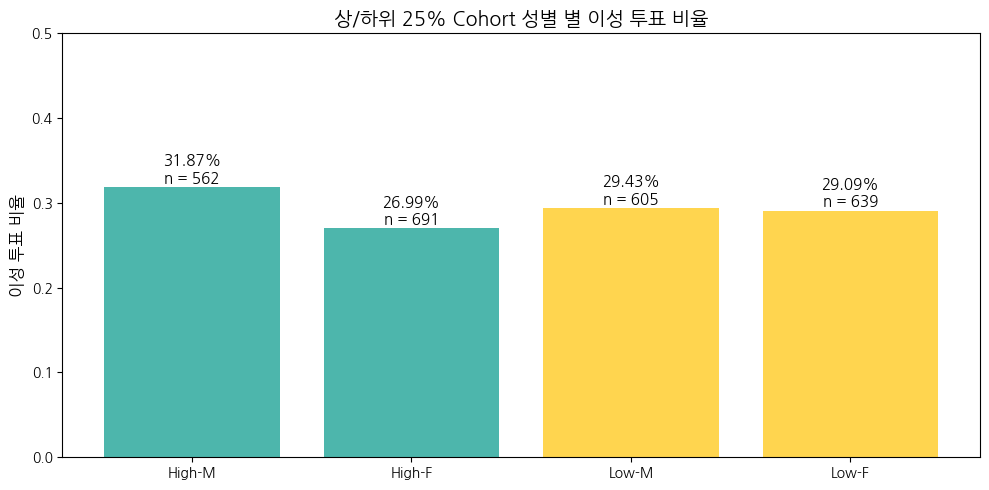

In [8]:
# 성별 세분화
## 각 성별 그룹 내부에서 이성에게 받은 투표의 비율 → 즉, 각 그룹 안에서 100% 기준


# 성별 유저 수
n_hm = len(cohort_high_df[cohort_high_df["gender"] == "M"])
n_hf = len(cohort_high_df[cohort_high_df["gender"] == "F"])
n_lm = len(cohort_low_df[cohort_low_df["gender"] == "M"])
n_lf = len(cohort_low_df[cohort_low_df["gender"] == "F"])

labels = ['High-M', 'High-F', 'Low-M', 'Low-F']
ratios = [h_m_ratio, h_f_ratio, l_m_ratio, l_f_ratio]
user_counts = [n_hm, n_hf, n_lm, n_lf]
colors = ['#4db6ac', '#4db6ac', '#ffd54f', '#ffd54f']

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, ratios, color=colors)

# 비율 + 유저 수 함께 표시
for bar, ratio, n in zip(bars, ratios, user_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{ratio:.2%}\nn = {n}", ha='center', fontsize=11)

plt.ylim(0, 0.5)
plt.ylabel("이성 투표 비율", fontsize=12)
plt.title("상/하위 25% Cohort 성별 별 이성 투표 비율", fontsize=14)
plt.tight_layout()
plt.show()


- 각 그룹 내 100% 기준
   - 해당 그룹 유저가 받은 투표 중 이성이 몇 %
   - 이성 인기도 / 매력도 해석에 적합

- 상위 남성(High-M)은 31.87%, 하위 남성(Low-M)은 29.43%
- 반면 여성은 하위 코호트(F)가 더 높음            
  → 리텐션 높은 남성은 이성에게 더 많은 투표를 받는 경향                  
  → 여성은 오히려 하위 코호트에서 이성투표 비율이 더 높음             

In [9]:
# ─────────────────────────────────────────────
# 0. 기본 준비  (성별 매핑)
# ─────────────────────────────────────────────
gender_map = merged_master_df[["user_id", "gender"]]

votes_with_gender = (
    votes_df
      .merge(gender_map, on="user_id", how="left")                   # 투표자 성별 → gender
      .merge(
          gender_map.rename(columns={"user_id": "chosen_user_id",
                                     "gender":   "chosen_gender"}),
          on="chosen_user_id", how="left")                           # 피투표자 성별 → chosen_gender
)

# ─────────────────────────────────────────────
# 1. 상·하위 25 % 코호트별·성별 유저 ID 집합
# ─────────────────────────────────────────────
high_male_ids   = cohort_high_df.loc[cohort_high_df["gender"] == "M", "user_id"]
high_female_ids = cohort_high_df.loc[cohort_high_df["gender"] == "F", "user_id"]
low_male_ids    = cohort_low_df .loc[cohort_low_df ["gender"] == "M", "user_id"]
low_female_ids  = cohort_low_df .loc[cohort_low_df ["gender"] == "F", "user_id"]

# ─────────────────────────────────────────────
# 2. 집합별 '이성에게 받은 투표' 필터링 함수
# ─────────────────────────────────────────────
def opposite_votes(df, id_series):
    """특정 ID 집합이 받은 '이성 투표'만 반환"""
    return df[
        (df["chosen_user_id"].isin(id_series)) &
        (df["gender"] != df["chosen_gender"])
    ]

high_male_received   = opposite_votes(votes_with_gender, high_male_ids)
high_female_received = opposite_votes(votes_with_gender, high_female_ids)
low_male_received    = opposite_votes(votes_with_gender, low_male_ids)
low_female_received  = opposite_votes(votes_with_gender, low_female_ids)

# ─────────────────────────────────────────────
# 3. 유저당 평균 이성 투표 수 계산
# ─────────────────────────────────────────────
avg_high_male   = len(high_male_received)   / len(high_male_ids)
avg_high_female = len(high_female_received) / len(high_female_ids)
avg_low_male    = len(low_male_received)    / len(low_male_ids)
avg_low_female  = len(low_female_received)  / len(low_female_ids)

# ─────────────────────────────────────────────
# 4. 요약 딕셔너리
# ─────────────────────────────────────────────
summary = {
    "Top 25% Cohort": {
        "남자 유저 수": len(high_male_ids),
        "여자 유저 수": len(high_female_ids),
        "남자 유저당 평균 이성 투표 수": round(avg_high_male,   2),
        "여자 유저당 평균 이성 투표 수": round(avg_high_female, 2)
    },
    "Bottom 25% Cohort": {
        "남자 유저 수": len(low_male_ids),
        "여자 유저 수": len(low_female_ids),
        "남자 유저당 평균 이성 투표 수": round(avg_low_male,    2),
        "여자 유저당 평균 이성 투표 수": round(avg_low_female,  2)
    }
}

summary


{'Top 25% Cohort': {'남자 유저 수': 562,
  '여자 유저 수': 691,
  '남자 유저당 평균 이성 투표 수': 83.54,
  '여자 유저당 평균 이성 투표 수': 70.44},
 'Bottom 25% Cohort': {'남자 유저 수': 605,
  '여자 유저 수': 639,
  '남자 유저당 평균 이성 투표 수': 48.46,
  '여자 유저당 평균 이성 투표 수': 47.14}}

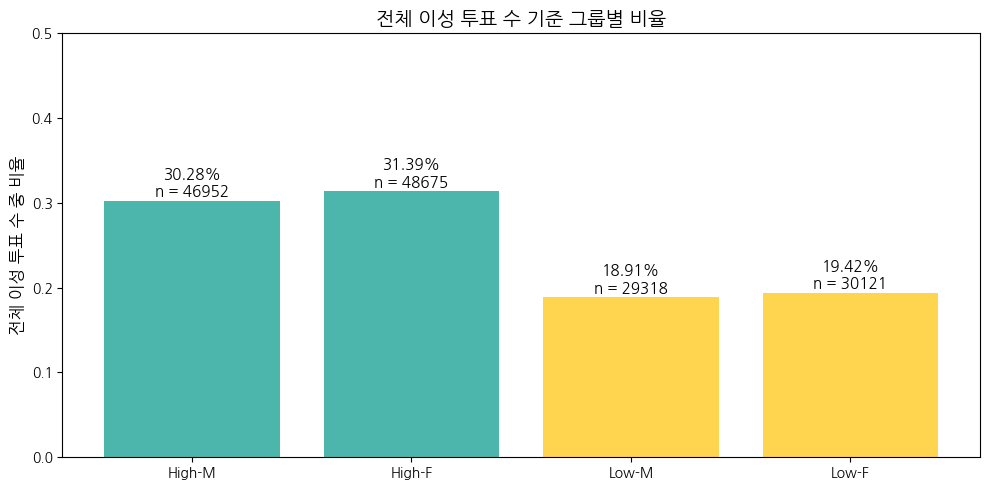

In [10]:
# 전체 기준 100%
# 전체 이성 투표 수 중에서, 어느 그룹이 얼마나 많이 받았는가?
## 분모가 전체 이성 투표 수, 분자가 각 그룹이 받은 이성 투표 수


# 절대 이성 투표 수
opp_counts = [h_m_opp, h_f_opp, l_m_opp, l_f_opp]
total_opp_votes = sum(opp_counts)
opp_ratios_global = [count / total_opp_votes for count in opp_counts]

labels = ['High-M', 'High-F', 'Low-M', 'Low-F']
colors = ['#4db6ac', '#4db6ac', '#ffd54f', '#ffd54f']

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, opp_ratios_global, color=colors)

for bar, ratio, count in zip(bars, opp_ratios_global, opp_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{ratio:.2%}\nn = {count}", ha='center', fontsize=11)

plt.ylim(0, 0.5)
plt.ylabel("전체 이성 투표 수 중 비율", fontsize=12)
plt.title("전체 이성 투표 수 기준 그룹별 비율", fontsize=14)
plt.tight_layout()
plt.show()

- 전체 기준 100%
   - 전체 이성 투표 중 해당 그룹이 얼마나 차지했나
   - 이성 투표를 많이 받은 그룹 중심 해석에 적합

- 상위 리텐션 그룹(High-M, High-F)이 전체 이성 투표의 약 61.7%를 차지
- 하위 그룹(Low-M, Low-F)은 38.3%만 차지         
→ 리텐션이 높은 유저일수록 이성에게 더 많은 투표를 받았고,                      
이는 리텐션과 인기(사회적 수신)의 관계 가능성을 시사함              

그룹 내부 기준으로는 High-M이 이성에게 받은 비율이 가장 높았지만,            
실제 전체 이성 투표 수 기준으로는 High-F가 더 많은 투표를 받았다.                     
이는 리텐션이 높고 여성인 유저들이 더 넓은 도달 범위를 갖고 있었다는 의미일 수 있다.

도달 범위란? (이 분석에서의 의미)               
전체 이성 유저로부터 얼마나 많은 투표를 받았는가                       
→ 즉, "이 그룹 유저들이 이성에게 얼마나 많이 보여졌고, 관심을 받았는가"의 지표                      

## 가설

### 1. 이성에게 7건 이상 투표를 받은 유저는 8일차 리텐션이 50% 이상일 확률이 높다.

In [36]:

# 1. 'opposite_votes_received' 기준으로 상위/하위 25% 유저 분리
quantiles = merged_master_df['opposite_votes_received'].quantile([0.25, 0.75])
low_threshold = quantiles.loc[0.25]
high_threshold = quantiles.loc[0.75]

# 2. 상위 25% / 하위 25% 유저 필터링
high_group = merged_master_df[merged_master_df['opposite_votes_received'] >= high_threshold]
low_group = merged_master_df[merged_master_df['opposite_votes_received'] <= low_threshold]

# 3. 각 그룹의 8일차 리텐션율 (50% 이상 여부로 분할)
high_ret_over50 = (high_group['retention_day8'] >= 0.5).mean()
low_ret_over50 = (low_group['retention_day8'] >= 0.5).mean()

# 4. 리텐션 비율 출력
{
    "상위 25% 유저 중 리텐션 50% 이상 비율": round(high_ret_over50 * 100, 2),
    "하위 25% 유저 중 리텐션 50% 이상 비율": round(low_ret_over50 * 100, 2),
    "상위 25% 기준 cutoff (이성 투표 수)": int(high_threshold),
    "하위 25% 기준 cutoff (이성 투표 수)": int(low_threshold)
}


{'상위 25% 유저 중 리텐션 50% 이상 비율': 51.23,
 '하위 25% 유저 중 리텐션 50% 이상 비율': 27.78,
 '상위 25% 기준 cutoff (이성 투표 수)': 88,
 '하위 25% 기준 cutoff (이성 투표 수)': 18}

- 상위 25% 유저는 하위 25%에 비해 리텐션이 약 23%p 더 높음

- 이성에게 받은 투표 수가 많을수록 리텐션이 높을 가능성 높음           
     
   → 가설은 지지됨            

In [ ]:
# 상/하위 25% 경계 계산
high_cut = merged_master_df["opposite_votes_received"].quantile(0.75)
low_cut  = merged_master_df["opposite_votes_received"].quantile(0.25)

# 그룹 분리
high25 = merged_master_df[merged_master_df["opposite_votes_received"] >= high_cut]
low25  = merged_master_df[merged_master_df["opposite_votes_received"] <= low_cut]

# 리텐션 50% 이상 카운트
count_high_retained = (high25["retention_day8"] >= 0.5).sum()
total_high          = len(high25)

count_low_retained  = (low25["retention_day8"] >= 0.5).sum()
total_low           = len(low25)

(count_high_retained, total_high, count_low_retained, total_low)

(605, 1181, 337, 1213)

In [ ]:
# 이성 투표 수가 0인 유저 수 확인
num_zero_vote_users = (merged_master_df["opposite_votes_received"] == 0).sum()
print(f"이성에게 한 표도 받지 못한 유저 수: {num_zero_vote_users}명")


이성에게 한 표도 받지 못한 유저 수: 107명


In [40]:
# 파일 재업로드가 필요하므로 다시 로드

# 이성 투표 수가 0인 유저 수
num_zero_vote_users = (merged_master_df["opposite_votes_received"] == 0).sum()

# 전체 유저 수
total_users = len(merged_master_df)

# 비율 계산
zero_vote_ratio = num_zero_vote_users / total_users

{
    "이성에게 0표 받은 유저 수": num_zero_vote_users,
    "전체 유저 수": total_users,
    "비율 (%)": round(zero_vote_ratio * 100, 2)
}


{'이성에게 0표 받은 유저 수': 107, '전체 유저 수': 4703, '비율 (%)': 2.28}

#### 이성에게 받은 투표 수 상·하위 25% 유저의 8일차 리텐션률(≥50%)

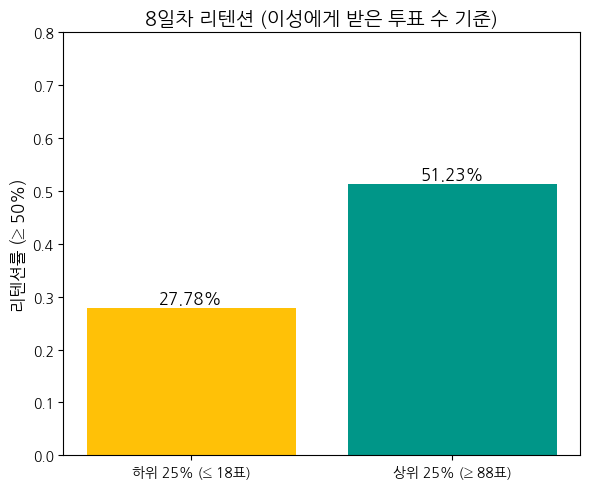

In [13]:

# 상하위 25% 기준으로 재정의
labels = ["하위 25% (≤ 18표)", "상위 25% (≥ 88표)"]
ratios = [low_ret_over50, high_ret_over50]
colors = ["#ffc107", "#009688"]

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, ratios, color=colors)

# 막대 위 텍스트
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{ratio:.2%}", ha="center", fontsize=12)

plt.ylim(0, 0.8)
plt.title("8일차 리텐션 (이성에게 받은 투표 수 기준)", fontsize=14)
plt.ylabel("리텐션률 (≥ 50%)", fontsize=12)
plt.tight_layout()
plt.show()


이 차이는 시각적으로도 뚜렷하며, 가설을 강하게 지지

In [14]:
import sys
sys.path.append('/home/eunyu/.local/share/pipx/shared/lib/python3.12/site-packages')


from statsmodels.stats.proportion import proportions_ztest

# 상하위 25% 유저 수
n_high = len(high_group)
n_low = len(low_group)

# 리텐션 50% 이상인 유저 수
count_high = (high_group['retention_day8'] >= 0.5).sum()
count_low = (low_group['retention_day8'] >= 0.5).sum()

# z-test
count = [count_high, count_low]
nobs = [n_high, n_low]
z_stat, p_value = proportions_ztest(count, nobs)

round(z_stat, 3), round(p_value, 5)


(11.74, 0.0)

- p-value가 0에 매우 가까움 → 두 집단 간 리텐션율 차이는 통계적으로 매우 유의미

- 즉, 이성에게 받은 투표 수가 상위 25%인 유저는 하위 25% 유저보다 8일차 리텐션 ≥ 50%일 확률이 확실히 더 높다고 볼 수 있다.



- H₀ (귀무가설): 이성에게 받은 투표 수가 리텐션(8일차 유지)에 영향을 주지 않는다

- H₁ (대립가설): 이성에게 7표 이상 받은 유저는 7표 미만보다 8일차 리텐션 확률이 유의하게 높다

이성에게 7표 이상 받은 유저는 그렇지 않은 유저보다 8일차 리텐션 확률이 유의하게 높다.                
즉, 이성의 피드백 경험이 잔존에 긍정적인 영향을 준다고 볼 수 있음.

이 결과는 리텐션 상승에 기여할 수 있는 초기 경험 요소로서,          
이성 투표 노출량(또는 매칭 수)을 초기 설계 지표로 활용할 근거가 될 수 있다.

### 2. 첫 3일 내 이성에게 받은 투표 수가 많을수록 리텐션이 높다.

In [16]:

# 먼저, 첫 3일 내 이성 투표 수를 계산
merged_master_df['opposite_votes_within_3d'] = merged_master_df['votes_within_3d'] * merged_master_df['opposite_vote_ratio']

# 상하위 25% 기준 나누기
q25 = merged_master_df['opposite_votes_within_3d'].quantile(0.25)
q75 = merged_master_df['opposite_votes_within_3d'].quantile(0.75)

low_25 = merged_master_df[merged_master_df['opposite_votes_within_3d'] <= q25]
high_25 = merged_master_df[merged_master_df['opposite_votes_within_3d'] >= q75]

# 각 그룹에서 8일차 리텐션이 50% 이상인 유저 비율
ret_rate_high = (high_25['retention_day8'] >= 0.5).mean()
ret_rate_low = (low_25['retention_day8'] >= 0.5).mean()

# 상하위 컷오프 값도 함께 출력
{
    "상위 25% (opposite_votes_within_3d ≥)": round(q75, 2),
    "하위 25% (opposite_votes_within_3d ≤)": round(q25, 2),
    "상위 25% 유저 중 리텐션 ≥50% 비율": round(ret_rate_high * 100, 2),
    "하위 25% 유저 중 리텐션 ≥50% 비율": round(ret_rate_low * 100, 2)
}


{'상위 25% (opposite_votes_within_3d ≥)': 43.68,
 '하위 25% (opposite_votes_within_3d ≤)': 7.98,
 '상위 25% 유저 중 리텐션 ≥50% 비율': 42.77,
 '하위 25% 유저 중 리텐션 ≥50% 비율': 34.69}

첫 3일 동안 많은 이성의 관심(투표)을 받은 유저일수록 리텐션이 높음

In [17]:
import sys
sys.path.append('/home/eunyu/.local/share/pipx/shared/lib/python3.12/site-packages')


from statsmodels.stats.proportion import proportions_ztest

# 표본 수
n_high = len(high_25)
n_low = len(low_25)

# 성공 수 (리텐션 ≥ 0.5)
count_high = (high_25['retention_day8'] >= 0.5).sum()
count_low = (low_25['retention_day8'] >= 0.5).sum()

# z-test
z_stat, p_value = proportions_ztest([count_high, count_low], [n_high, n_low])

# 결과 포맷
{
    "p1 (상위 25% 리텐션)": round(count_high / n_high, 3),
    "p2 (하위 25% 리텐션)": round(count_low / n_low, 3),
    "z 통계량": round(z_stat, 3),
    "p-value": format(p_value, ".4f"),
    "결론": "귀무가설 기각: 첫 3일 내 이성 투표 수와 리텐션 간 유의미한 차이 있음" if p_value < 0.05 else "귀무가설 채택: 유의미한 차이 없음"
}


{'p1 (상위 25% 리텐션)': 0.428,
 'p2 (하위 25% 리텐션)': 0.347,
 'z 통계량': 4.021,
 'p-value': '0.0001',
 '결론': '귀무가설 기각: 첫 3일 내 이성 투표 수와 리텐션 간 유의미한 차이 있음'}

- H₀ (귀무가설): 첫 3일 내 이성에게 받은 투표 수와 8일차 리텐션 사이에는 관련이 없다

- H₁ (대립가설): 첫 3일 내 이성에게 받은 투표 수가 많을수록 8일차 리텐션 확률이 높다

 초기(3일 내) 이성의 주목을 많이 받은 유저일수록 서비스에 더 오래 남을 가능성이 높다는 가설이 데이터에 의해 지지

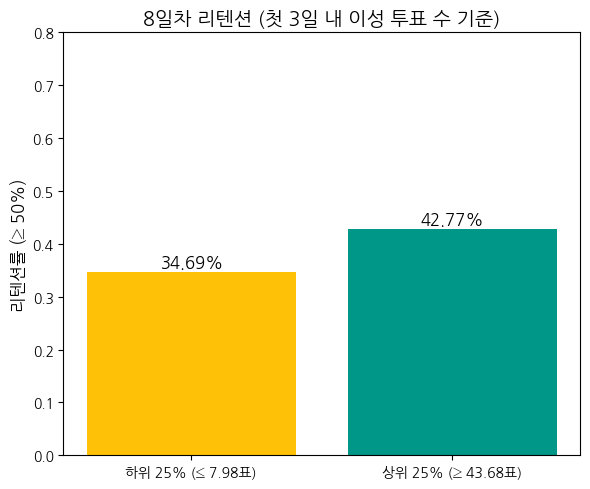

In [19]:

# 레이블 및 값
labels = ["하위 25% (≤ 7.98표)", "상위 25% (≥ 43.68표)"]
ratios = [count_low / n_low, count_high / n_high]
colors = ["#ffc107", "#009688"]

# 막대그래프 시각화
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, ratios, color=colors)

# 막대 위에 비율 표시
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{ratio:.2%}", ha="center", fontsize=12)

plt.ylim(0, 0.8)
plt.title("8일차 리텐션 (첫 3일 내 이성 투표 수 기준)", fontsize=14)
plt.ylabel("리텐션률 (≥ 50%)", fontsize=12)
plt.tight_layout()
plt.show()


- 상위 25% (≥ 43.68표): 리텐션 ≥ 50% 비율 42.8%

- 하위 25% (≤ 7.98표): 리텐션 ≥ 50% 비율 34.7%

Z-test 결과에 따르면 이 차이는 통계적으로 유의미하며,                     
초기(3일 내) 이성의 관심을 더 많이 받은 유저가 더 오래 남는 경향이 있다는 가설을 지지

##### 이성에게 받은 투표 수가 속한 구간에 따라 유저의 8일차 리텐션 확률이 달라진다

In [ ]:

# 분석을 위해 복사
df = merged_master_df.copy()

# 리텐션 이진화
df["retained"] = df["retention_day8"] >= 0.5

# 이성 투표 수 구간 설정 (vote_bin 생성)
df["vote_bin"] = pd.cut(
    df["opposite_votes_received"],
    bins=[-1, 7, 20, 50, 100, df["opposite_votes_received"].max()],
    labels=["≤7", "8–20", "21–50", "51–100", "100+"]
)

# 교차표 생성: 투표 구간 vs 리텐션 여부
ct = pd.crosstab(df["vote_bin"], df["retained"])
ct


retained,False,True
vote_bin,,
≤7,419,125
8–20,528,247
21–50,778,446
51–100,667,513
100+,472,508


이성에게 받은 투표 수가 많을수록 리텐션(True) 비율이 뚜렷하게 증가
- ≤7표: 리텐션률 약 23%
- 100+표: 리텐션률 약 52%

In [22]:
import sys
sys.path.append('/home/eunyu/.local/share/pipx/shared/lib/python3.12/site-packages')

from scipy.stats import chi2_contingency

# 카이제곱 검정 수행
chi2_stat, p_value, dof, expected = chi2_contingency(ct)

# 결과 요약
{
    "카이제곱 통계량": round(chi2_stat, 3),
    "p-value": format(p_value, ".4f"),
    "자유도": dof,
    "결론": "귀무가설 기각: 이성 투표 수 구간과 리텐션 간 유의미한 연관 있음" if p_value < 0.05 else "귀무가설 채택: 유의미한 차이 없음"
}


{'카이제곱 통계량': 156.276,
 'p-value': '0.0000',
 '자유도': 4,
 '결론': '귀무가설 기각: 이성 투표 수 구간과 리텐션 간 유의미한 연관 있음'}

χ² = 156.276 > 9.488, p-value ≈ 0 이므로 귀무가설을 기각하고            
“이성 투표 수 구간과 리텐션 간에는 통계적으로 유의미한 연관이 있다”는 결론

### 3. 이성에게 받은 투표 수 상위 25% 유저는 하위 25%보다 평균 리텐션이 높다.

In [23]:
# 상하위 25% 유저 분리 (이성 투표 수 기준)
quantiles = merged_master_df["opposite_votes_received"].quantile([0.25, 0.75])
low25 = merged_master_df[merged_master_df["opposite_votes_received"] <= quantiles.loc[0.25]]
high25 = merged_master_df[merged_master_df["opposite_votes_received"] >= quantiles.loc[0.75]]

# 평균 리텐션 계산
mean_ret_high = high25["retention_day8"].mean()
mean_ret_low = low25["retention_day8"].mean()

# 결과 정리
{
    "상위 25% 평균 리텐션": round(mean_ret_high, 3),
    "하위 25% 평균 리텐션": round(mean_ret_low, 3),
    "차이": round(mean_ret_high - mean_ret_low, 3)
}


{'상위 25% 평균 리텐션': 0.494, '하위 25% 평균 리텐션': 0.429, '차이': 0.066}

이성 투표 수가 많은 유저일수록 평균적으로 더 오래 남는 경향이 있으며,          
약 6.6%p 차이는 실질적으로도 의미 있는 차이

##### t-test

In [24]:
import sys
sys.path.append('/home/eunyu/.local/share/pipx/shared/lib/python3.12/site-packages')


from scipy.stats import ttest_ind

# 두 집단의 8일차 리텐션값
ret_high = high25["retention_day8"].dropna()
ret_low = low25["retention_day8"].dropna()

# 독립표본 t-test
t_stat, p_val = ttest_ind(ret_high, ret_low, equal_var=False)  # Welch’s t-test (분산 다를 수 있음)

# 결과 정리
{
    "상위 25% 평균 리텐션": round(ret_high.mean(), 3),
    "하위 25% 평균 리텐션": round(ret_low.mean(), 3),
    "t 통계량": round(t_stat, 3),
    "p-value": format(p_val, ".4f"),
    "결론": "귀무가설 기각: 이성 투표 수와 리텐션 평균 간 유의미한 차이 있음" if p_val < 0.05 else "귀무가설 채택: 유의미한 차이 없음"
}


{'상위 25% 평균 리텐션': 0.494,
 '하위 25% 평균 리텐션': 0.429,
 't 통계량': 13.451,
 'p-value': '0.0000',
 '결론': '귀무가설 기각: 이성 투표 수와 리텐션 평균 간 유의미한 차이 있음'}

많은 이성 투표를 받은 유저는 평균적으로 더 오래 남는다는 주장은 통계적으로도 유의미

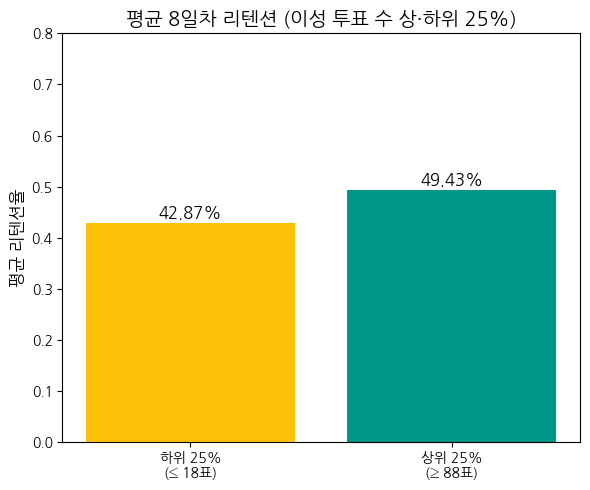

In [25]:

# 평균 리텐션 값
means = [ret_low.mean(), ret_high.mean()]
labels = ["하위 25%\n(≤ 18표)", "상위 25%\n(≥ 88표)"]
colors = ["#ffc107", "#009688"]

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, means, color=colors)

# 막대 위에 값 표시
for bar, m in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{m:.2%}", ha="center", fontsize=12)

plt.ylim(0, 0.8)
plt.title("평균 8일차 리텐션 (이성 투표 수 상·하위 25%)", fontsize=14)
plt.ylabel("평균 리텐션율", fontsize=12)
plt.tight_layout()
plt.show()


## 2. 소속학교, 학년, 성별

In [26]:
# 8일차 리텐션 기준으로 High / Low 재분류 (≥25%)
df['ret_group_25'] = df['retention_day8'].apply(lambda x: 'High25' if x >= 0.25 else 'Low25')

# 성별 분포
gender_dist_25 = df.groupby(['ret_group_25', 'gender'])['user_id'].count().unstack(fill_value=0)
gender_dist_25_ratio = gender_dist_25.div(gender_dist_25.sum(axis=1), axis=0)

# 학년 분포
grade_dist_25 = df.groupby(['ret_group_25', 'grade'])['user_id'].count().unstack(fill_value=0)
grade_dist_25_ratio = grade_dist_25.div(grade_dist_25.sum(axis=1), axis=0)

# 학교 분포
school_dist_25 = df.groupby(['ret_group_25', 'school_id'])['user_id'].count().unstack(fill_value=0)
school_dist_25_ratio = school_dist_25.div(school_dist_25.sum(axis=1), axis=0)

In [ ]:
# 성별, 학년, 학교 분포 비율 테이블 디스플레이
gender_dist_25_ratio_display = gender_dist_25_ratio.copy()
grade_dist_25_ratio_display = grade_dist_25_ratio.copy()

# 상위 10개 학교 기준으로 필터링해서 보기 좋게
top10_schools = school_dist_25_ratio.sum().sort_values(ascending=False).head(10).index
school_dist_25_ratio_display = school_dist_25_ratio[top10_schools]


display(gender_dist_25_ratio_display)
display(grade_dist_25_ratio_display)
display(school_dist_25_ratio_display)


gender,F,M
ret_group_25,,
High25,0.539049,0.460951
Low25,0.521008,0.478992


grade,1.0,2.0,3.0
ret_group_25,,,
High25,0.360820,0.421902,0.217277
Low25,0.210084,0.403361,0.386555


school_id,1719.0,5372.0,5491.0,5520.0,1478.0,369.0,4516.0,271.0,352.0,4426.0
ret_group_25,,,,,,,,,,
High25,0.104930,0.097949,0.095550,0.097949,0.095768,0.116492,0.095768,0.100131,0.100131,0.095332
Low25,0.478992,0.226891,0.142857,0.058824,0.050420,0.008403,0.025210,0.008403,0.000000,0.000000


-  큰 차이는 없지만, 여성 비율이 High25 그룹에서 약간 높음
- High25 그룹은 1학년 비중이 확연히 높고,  Low25 그룹은 3학년 비중이 압도적으로 높음
   - 학년이 낮을수록 리텐션이 높을 가능성
- 352, 4426번 학교는 모두 High25에만 존재
- 1719번은 Low25의 절반 가까이를 차지
   - 리텐션이 높은 학교는 특정되어 있고
   - 리텐션이 낮은 학교에서는 개선이 시급

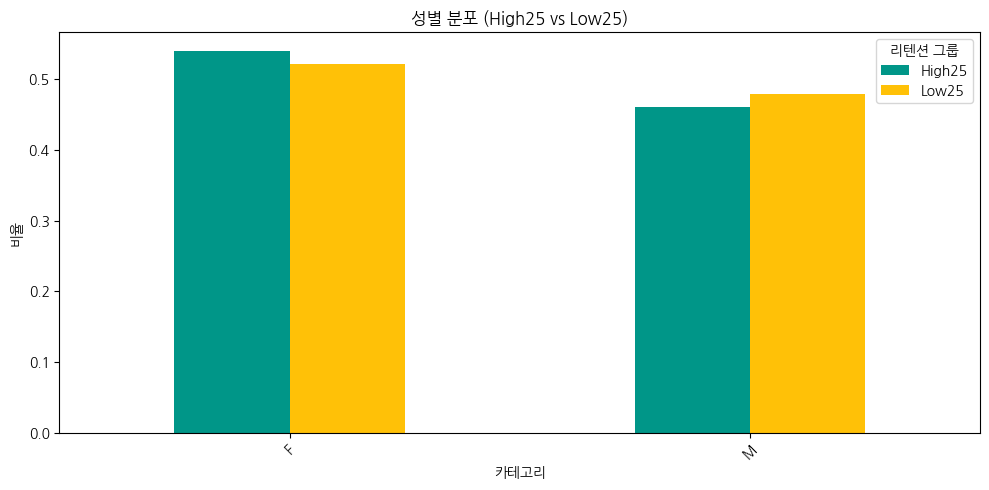

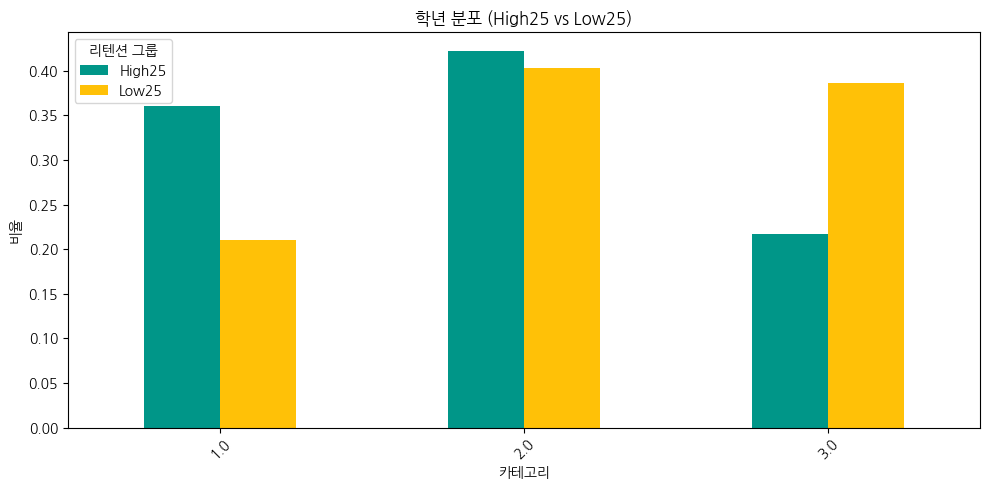

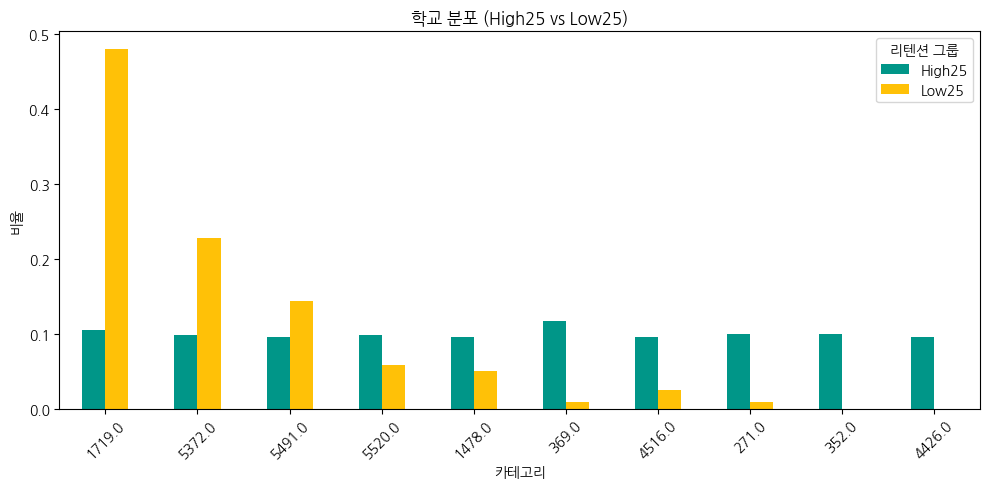

In [ ]:
# 사용자 지정 색상 지정
colors = ['#009688', '#ffc107']  # High25: 민트, Low25: 노랑

# 시각화 함수 (색상 적용)
def plot_group_dist_custom(dist_df, title):
    dist_df.T.plot(kind='bar', figsize=(10, 5), color=colors)
    plt.title(title)
    plt.ylabel('비율')
    plt.xlabel('카테고리')
    plt.xticks(rotation=45)
    plt.legend(title='리텐션 그룹')
    plt.tight_layout()
    plt.show()

# 성별 분포 시각화
plot_group_dist_custom(gender_dist_25_ratio, "성별 분포 (High25 vs Low25)")

# 학년 분포 시각화
plot_group_dist_custom(grade_dist_25_ratio, "학년 분포 (High25 vs Low25)")

# 상위 10개 학교 기준 학교 분포 시각화
plot_group_dist_custom(school_dist_25_ratio[top10_schools], "학교 분포 (High25 vs Low25)")


In [29]:
import sys
sys.path.append('/home/eunyu/.local/share/pipx/shared/lib/python3.12/site-packages')

from scipy.stats import chi2_contingency


# 1. 성별 분포 카이제곱 검정
gender_chi2, gender_p, _, _ = chi2_contingency(gender_dist_25)

# 2. 학년 분포 카이제곱 검정
grade_chi2, grade_p, _, _ = chi2_contingency(grade_dist_25)

# 3. 상위 10개 학교 분포 카이제곱 검정
school_chi2, school_p, _, _ = chi2_contingency(school_dist_25[top10_schools])

{
    "성별 유의확률 (p-value)": gender_p,
    "학년 유의확률 (p-value)": grade_p,
    "학교 유의확률 (p-value)": school_p
}


{'성별 유의확률 (p-value)': 0.7667583937463591,
 '학년 유의확률 (p-value)': 1.3153432552318366e-05,
 '학교 유의확률 (p-value)': 3.003116404932101e-42}

- 성별은 리텐션 그룹 간 큰 차이가 없음

- 학년과 소속 학교는 리텐션 그룹을 유의미하게 구분하는 요인

In [30]:
#  리텐션 그룹 구분에 주요한 학년 및 학교

# 1. 학년별 High25 vs Low25 비율 차이 계산
grade_diff = (grade_dist_25_ratio.loc['High25'] - grade_dist_25_ratio.loc['Low25']).sort_values(ascending=False)

# 2. 상위 10개 학교 기준, High25 vs Low25 비율 차이 계산
school_diff = (school_dist_25_ratio.loc['High25', top10_schools] - school_dist_25_ratio.loc['Low25', top10_schools]).sort_values(ascending=False)

# 상위 차이만 보기 좋게 정리
grade_diff_df = grade_diff.reset_index().rename(columns={0: '비율 차이', 'grade': '학년'})
school_diff_df = school_diff.reset_index().rename(columns={0: '비율 차이', 'school_id': '학교ID'})

grade_diff_df, school_diff_df


(    학년     비율 차이
 0  1.0  0.150736
 1  2.0  0.018541
 2  3.0 -0.169277,
      학교ID     비율 차이
 0   369.0  0.108089
 1   352.0  0.100131
 2  4426.0  0.095332
 3   271.0  0.091728
 4  4516.0  0.070558
 5  1478.0  0.045348
 6  5520.0  0.039126
 7  5491.0 -0.047307
 8  5372.0 -0.128941
 9  1719.0 -0.374061)

- 1학년 유저가 리텐션이 가장 좋고, 3학년은 가장 낮다.
- 369, 352, 4426, 271번 학교는 리텐션이 높고, 1719번 학교는 매우 낮은 리텐션을 보인다.

- 1학년 신입 유저는 서비스 초기 적응도가 높고, 잔존률도 높음

- 학교별 차이는 최대 30% 이상 차이

- 리텐션 높은 학교	369, 352, 4426, 271	▲ 약 9% ~ 11%
- 리텐션 낮은 학교	1719, 5372, 5491	▼ 약 -13% ~ -37%

In [31]:
## 학교별 첫날 평균 투표 수 / 질문 수 비교 (상위·하위 리텐션 그룹 중 일부)

# 필요한 컬럼: user_id, school_id, first_vote_date, firstquestion_id

# 첫날 기준으로 유저별 투표/질문 수 세기 위해 필요한 전처리
df_first_day = df.copy()

# 날짜 변환
df_first_day['first_vote_date'] = pd.to_datetime(df_first_day['first_vote_date'], errors='coerce')
df_first_day['sign_up_date'] = pd.to_datetime(df_first_day['sign_up_date'], errors='coerce')

# 기준: first_vote_date 기준으로 같은 날 투표한 유저들의 수
vote_counts_by_school = df_first_day.groupby(['school_id', 'first_vote_date'])['user_id'].count().reset_index(name='vote_count')
vote_avg_by_school = vote_counts_by_school.groupby('school_id')['vote_count'].mean().reset_index(name='avg_firstday_vote_count')

# 기준: first_vote_date 기준으로 질문 생성자 수
question_counts_by_school = df_first_day.dropna(subset=['firstquestion_id']).groupby(['school_id', 'first_vote_date'])['user_id'].nunique().reset_index(name='question_count')
question_avg_by_school = question_counts_by_school.groupby('school_id')['question_count'].mean().reset_index(name='avg_firstday_question_count')

# 병합
school_engagement = pd.merge(vote_avg_by_school, question_avg_by_school, on='school_id', how='outer')

# 상위 10개 리텐션 학교 + 하위 5개 리텐션 학교에 대한 필터링
top_schools_ids = school_diff_df.sort_values("비율 차이", ascending=False).head(5)['학교ID'].tolist()
bottom_schools_ids = school_diff_df.sort_values("비율 차이", ascending=True).head(5)['학교ID'].tolist()
target_school_ids = top_schools_ids + bottom_schools_ids

school_engagement_filtered = school_engagement[school_engagement['school_id'].isin(target_school_ids)]

school_engagement_filtered.sort_values('avg_firstday_vote_count', ascending=False)


,school_id,avg_firstday_vote_count,avg_firstday_question_count
1,352.0,1.006579,1.006579
8,5491.0,1.004415,1.004415
9,5520.0,1.004405,1.004405
0,271.0,1.004367,1.004367
7,5372.0,1.004219,1.004219
2,369.0,1.001873,1.001873
4,1719.0,1.001862,1.001862
3,1478.0,1.000000,1.000000
5,4426.0,1.000000,1.000000
6,4516.0,1.000000,1.000000


거의 모든 학교에서 첫날 투표 수와 질문 수는 1건 내외로 매우 유사

In [32]:
## 학교별 첫날 친구 수 평균

# first_vote_date가 있는 유저만 추출
df_friends = df.dropna(subset=["first_vote_date", "school_id", "period_friend_count_y"])

# 학교 + first_vote_date 기준으로 친구 수 평균
friend_counts_by_school = (
    df_friends.groupby(['school_id', 'first_vote_date'])['period_friend_count_y']
    .mean()
    .reset_index(name='avg_friend_count')
)

# 학교별 평균
friend_avg_by_school = (
    friend_counts_by_school.groupby('school_id')['avg_friend_count']
    .mean()
    .reset_index(name='avg_firstday_friend_count')
)

# 리텐션 상/하위 학교에 대한 필터링
friend_avg_filtered = friend_avg_by_school[friend_avg_by_school['school_id'].isin(target_school_ids)]

# 정렬
friend_avg_filtered.sort_values("avg_firstday_friend_count", ascending=False)


,school_id,avg_firstday_friend_count
4,1719.0,59.095903
6,4516.0,48.529412
9,5520.0,47.838106
3,1478.0,47.159551
7,5372.0,45.996835
5,4426.0,41.498856
2,369.0,40.513109
1,352.0,38.084430
8,5491.0,35.487859
0,271.0,33.716157


- 친구 수가 많은 학교가 오히려 리텐션이 낮은 경우가 있음         
→ 예: 1719번 학교는 평균 친구 수 59.1명으로 최다, 그러나 리텐션은 최하                
                   
- 반면, 리텐션이 높은 학교(369, 352, 271 등) 은 친구 수는 30~40명 수준